# CPSC 599.83 - Project 1.1

*Tyler Gillson - 10170105*

## The Dataset

#### Overview
<p>I have chosen to work with the Draw A Circle (DAC) data, which was generated by Morshed ul Islam via Mechanical Turk HITs. DAC is a biometric 2nd factor authentication technology that Morshed is developing for the purpose of his PHD thesis.
<p>DAC is an Android app which is available in the Google Play store. Users begin by creating a profile, which is accomplished by completing 10 registration rounds. Each round consists of two phases. In the first phase, users trace three ideal circles which are visible on the screen throughout the tracing process. In the second phase, a circle is flashed on the screen for 3 seconds and the user traces where they thought it was after it has disappeared.<br>
<p>Upon completion of the registration rounds, a matrix consisting of 40 vectors (each of which represents a single circle and contains 65 elements) is stored on a server - becoming the 'profile' for that particular user. Users authenticate themselves via 5 verification rounds, which are conducted identically to the registration rounds. The 20x65 verification matrix is then compared to the 40x65 registration matrix using a generalized k-NN Divergence Estimator with pre-defined thresholds in order to decide profile matches.<br>
<p>Due to the inevitable variation in a particular user's verification data over time - whether due to randomness or improvement in skill - Morshed employs reinforcement learning techniques to evolve the registration profile each time a user successfully authenticates themselves. This is preferable to allowing user profiles to grow over time because the app will not have to deal with ever-increasing quantities of data to process.<br> 
<p>The original data was split into two distinct sets: registration and verification. Since both datasets are generated via the same process, I chose to combine them for the sake of simplicity. Also, because the combined dataset will provide larger sample sizes and therefore a more accurate analysis.

#### Notes on the Data
The majority of the features (60/65) are collected at 10 different point around the circumference of the circles. From now on I will refer to each of the following bullets as a feature group:
 - Error relative to the ideal circle at each point
 - Speed x/y at each point
 - Pressure at each point
 - Event size at each point (contact surface area of finger)
 - Orientation in x, y, and z axes at each point

The other five features are not specific to each point and will be addressed separately:
 - eStart = deviation of initial contact point from the nearest point on the ideal circle
 - eCenter = deviation of the drawn circle's centroid relative to the ideal circle's centroid
 - eRadius = difference in radii between drawn & ideal circles
 - direction = 1 for clockwise, -1 for anti-clockwise
 - timediff = time taken to draw the circle

#### Why I Chose It
<p>I am fascinated by the difficulties inherent in analysing and visualizing multivariate data. I was initially drawn to the DAC dataset because it was richly featured and would lend itself well to such an analysis. Another reason that I wanted to work with the DAC data was because of the complexity involved in Morshed's project. I saw it as an opportunity to expose myself to advanced concepts such as information entropy, mutual information, and reinforcement learning.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<span style="color:red">The raw code for this notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.</span>''')

## Transformations

#### Overview
Overall, there was very little data munging to perform. All the transformations I did perform are as follows:
 - Added a meaningful header row to each of the raw data tables
 - Concatenated registration and verification data into one dataframe
 - Performed a feature reduction method to combine 30 columns of gyroscopic orientation data into 10

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import sklearn.metrics as skm

import plotly.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', color_codes=True, font_scale=1.3)

In [3]:
pd.options.display.max_columns = 65
pd.options.display.max_rows = 5

### Import & sample data

In [4]:
all_reg = pd.read_csv('all_DACRRData.csv')
all_ver = pd.read_csv('all_DACVData.csv')
dac_index = pd.read_csv('index.csv')

Registration data:

In [5]:
all_reg.sample(3)

ID       F1      F2      F3      F4       F5       F6      F7  \
2446   Igna   7.8938  5.6134  2.0100  2.6163   7.0600   3.5795  4.4742   
899   Casey  18.3881  9.4031  3.8372  3.5515  12.0086  10.1348  4.4461   
7073  tevaz   4.3461  0.8584  1.7968  1.3735   7.3471  10.3816  5.2908   

           F8       F9      F10        F11      F12        F13       F14  \
2446  14.6086   7.5423   4.3412  1447.6428  40.1501  1131.3103  542.6353   
899    8.9203  11.0853  18.8525   478.5536  72.6763   731.8760  185.5909   
7073   1.7194   1.8043   6.7904   205.7495   8.1784   783.2556  427.7397   

           F15        F16       F17        F18       F19       F20        F21  \
2446  167.5818   110.9503  702.1517  1517.2520  852.6254  499.8610  1144.5724   
899   171.8327   609.3851   55.7135   467.5768  448.6767  179.7255   451.3318   
7073  231.2771  1077.1183  258.9982   905.3428  926.5593  327.5298   669.5334   

          F22       F23        F24       F25        F26       F27        F28  \
2446   9.6435  833.8726  1263.8838  400.3213  1870.9402   89.5737  1067.8169   
899   68.3208  645.8171   498.8488  101.9134   443.7568  244.5899   580.8757   
7073  40.5942  556.3413   494.4761  265.8174   949.8829    0.0000     0.0000   

            F29       F30     F31   ...         F54       F55     F56  \
2446  1339.0698  605.0846  0.1843   ...    282.9181  -65.7257 -3.1527   
899    316.8463  200.2460  1.0000   ...    148.3598 -102.0931  4.1326   
7073  1027.8525  606.2320  0.7922   ...    155.4219  -36.8750 -3.2969   

           F57       F58     F59       F60       F61     F62      F63  \
2446  282.3801  -65.6967 -3.0325  284.3559  -65.0570 -2.6497  283.638   
899   148.6417 -101.7677  3.7939  147.8653 -101.4574  3.7348  147.661   
7073  155.4531  -39.5156 -1.2344  155.4531  -39.7500 -1.4531  155.375   

           F64     F65       F66       F67     F68       F69       F70  \
2446  -65.3922 -2.9586  283.6380  -65.3922 -2.9586  283.3752  -66.2686   
899  -101.2711  4.0120  146.8972 -101.0322  4.1743  152.0872 -102.1170   
7073  -39.8750 -2.0625  155.4063  -38.5156 -1.8438  155.4219  -39.5313   

         F71       F72       F73     F74       F75       F76     F77  \
2446 -3.4563  282.8221  -66.7620 -3.8050  282.8221  -66.7620 -3.8050   
899   2.6832  150.5225 -101.8120  3.2476  149.7610 -101.8042  3.5195   
7073 -1.4531  155.3125  -37.4844 -3.9531  155.7031  -39.9844  0.4219   

           F78       F79     F80     F81      F82  F83     F84     F85  
2446  283.2350  -66.6611 -3.7557  4.6704   8.8918 -1.0  0.0097  7.7500  
899   148.5605 -102.2529  4.1962  8.5595  15.7698 -1.0  0.0210  7.3333  
7073  155.5313  -37.1875 -4.1406  8.7496   6.2088 -1.0  0.0140  1.3333  

[3 rows x 86 columns]

Verification Data:

In [6]:
all_ver.sample(3)

ID      F1      F2      F3      F4      F5       F6       F7  \
13239  Robinson  7.2857  8.8180  3.9961  1.2866  9.8837   6.4397   6.6597   
8576        kyo  2.2215  0.7699  5.2467  0.6289  1.9151   1.9050   2.4337   
6687         jm  0.7967  6.1072  4.4735  3.7171  5.1285  19.0984  20.1047   

            F8       F9     F10        F11        F12        F13        F14  \
13239  13.8214  17.2051  7.7018  1657.2659   184.8747  2062.9119  1424.2245   
8576    4.9678   8.1991  3.0849  1563.4779   152.3432   878.7593   838.4883   
6687   11.6914   4.1608  3.2531  5475.6309  2414.1008  1746.7457   910.4927   

             F15        F16       F17        F18        F19        F20  \
13239   625.1185  1593.1826  201.9410  1789.5442  1451.7319  1380.7435   
8576    393.4485   880.7057  163.6575  1068.8760   382.0887   319.4536   
6687   1397.4397  2971.7471  713.4037  2922.1670  3530.0200  1646.9067   

             F21       F22        F23        F24        F25        F26  \
13239  2151.8577  166.0140  2261.6597  1585.4364  1397.1555  2279.2427   
8576    909.7486    1.0897   509.2623   196.0150   351.0441  1008.6174   
6687   4239.4795  659.0159  3374.5637  2284.2083  2228.8938  3763.2476   

            F27        F28        F29        F30     F31  ...         F54  \
13239  645.8431  1886.0449  1880.2463  1211.3057  1.0000  ...    254.3195   
8576   376.8738   817.3524   425.4815   870.1071  0.7513  ...    248.7898   
6687   852.9570  2961.9746  3145.2578  2059.0203  1.0000  ...    133.5540   

          F55     F56       F57     F58     F59       F60     F61     F62  \
13239  0.5304 -0.5368  254.3374  0.5273 -0.5139  254.3796  0.5204 -0.4576   
8576  -3.0792 -0.1677  248.7652 -3.0669 -0.1720  248.1689 -3.0272 -0.2556   
6687  -0.5369 -0.5734  133.3839 -0.5329 -0.5934  133.3839 -0.5329 -0.5934   

            F63     F64     F65       F66     F67     F68       F69     F70  \
13239  254.3796  0.5204 -0.4576  254.3866  0.5253 -0.4265  254.3866  0.5253   
8576   248.6895 -2.9961 -0.1169  249.3079 -2.9697  0.2966  249.4424 -2.9658   
6687   134.0193 -0.5330 -0.5764  134.0193 -0.5330 -0.5764  134.0193 -0.5330   

          F71       F72     F73     F74       F75     F76     F77       F78  \
13239 -0.4265  254.3410  0.5409 -0.4587  254.3410  0.5409 -0.4587  254.3361   
8576   1.1050  249.3803 -2.9415  1.1505  249.0417 -2.9706  1.1169  248.8886   
6687  -0.5764  134.2822 -0.5566 -0.5385  134.2822 -0.5566 -0.5385  134.2822   

          F79     F80      F81      F82  F83     F84    F85  
13239  0.5417 -0.4649  11.5205   6.3830  1.0  0.0053  10.00  
8576  -3.0143  0.1645   5.3568   7.7062  1.0  0.0146   3.50  
6687  -0.5566 -0.5385  10.0928  12.0482  1.0  0.0034   5.75  

[3 rows x 86 columns]

Index data:
 - Contains information about device types and the success/failure of each verification attempt

In [7]:
dac_index.sample(3)

id           name                                           reg_file  \
578  1294  thelawgoddess  data/registration_thelawgoddess_H7M20S21_SM_G9...   
240  1596       indreesh    data/registration_indreesh_H11M45S32_Nexus6.csv   
617   636         vaitsa      data/registration_vaitsa_H20M44S17_Redmi3.csv   

                                              ver_file       date  status  \
578  data/verification_thelawgoddess_H7M30S33_SM_G9...  9/16/2017       1   
240    data/verification_indreesh_H13M11S37_Nexus6.csv  9/19/2017       0   
617      data/verification_vaitsa_H20M54S45_Redmi3.csv  9/14/2017       1   

                           message  
578  Pass! Enter code.;Code: 73520  
240        Fail! Try next round.;   
617        Pass! Try next round.;

### Update the header rows

In [8]:
# Create new column header:
cols = ['ID',
        'error1','error2','error3','error4','error5',
        'error6','error7','error8','error9','error10',
        'speedx1','speedy1','speedx2','speedy2','speedx3','speedy3',
        'speedx4','speedy4','speedx5','speedy5','speedx6','speedy6',
        'speedx7','speedy7','speedx8','speedy8',
        'speedx9','speedy9','speedx10','speedy10',
        'pres1','pres2','pres3','pres4','pres5',
        'pres6','pres7','pres8','pres9','pres10',
        'events1','events2','events3','events4','events5',
        'events6','events7','events8','events9','events10',
        'orix1','oriy1','oriz1','orix2','oriy2','oriz2','orix3','oriy3','oriz3',
        'orix4','oriy4','oriz4','orix5','oriy5','oriz5','orix6','oriy6','oriz6',
        'orix7','oriy7','oriz7','orix8','oriy8','oriz8','orix9','oriy9','oriz9',
        'orix10','oriy10','oriz10',
        'eStart','eCenter','direction','timediff','eRadius']

# Apply new header to registration data:
all_reg.columns = cols
all_reg.shape

(7800, 86)

In [9]:
# Apply new header to verification data:
all_ver.columns = cols
all_ver.shape

(17820, 86)

### Combine registration & verification data into one master dataframe

In [10]:
all_data = pd.concat([all_reg, all_ver], ignore_index=True)
all_data.shape

(25620, 86)

### Convert orientation data into single vectors for each point
- For each row in the dataset, I combined the x, y, and z orientation readings from the gyroscope into their longest diagonal.
- Morshed employs this same feature reduction technique on his end, so I had to reproduce it from the raw data.
- Doing so compressed the number of features from 85 to 65.
    

In [11]:
import math

def reduce_features(df):
    all_orients = []
    
    for index, row in df.iterrows():
        orients = [math.sqrt(math.pow(row['orix'+str(i)],2) +
                             math.pow(row['oriy'+str(i)],2) + 
                             math.pow(row['oriz'+str(i)],2)) for i in range(1,11)]
        all_orients.append(orients)

    all_orients_df = pd.DataFrame(all_orients, 
        columns=['orient1','orient2','orient3','orient4','orient5',
                 'orient6','orient7','orient8','orient9','orient10'])

    df = df.drop(df.loc[:, 'orix1':'oriz10'], axis=1)
    df = pd.concat([df, all_orients_df], axis=1)
    return df

In [12]:
# Take a peek at the result:
all_data = reduce_features(all_data)
all_data.head(3)

ID  error1   error2   error3  error4   error5   error6  \
0  A3MC5OA9RXOOFH  5.2326   3.7874   2.4150  6.7158  11.3644  19.8435   
1  A3MC5OA9RXOOFH  3.3471  10.8631  13.3662  2.5906  10.8540  10.3874   
2  A3MC5OA9RXOOFH  9.9535   4.4871   7.0042  1.4158   7.7458  11.1133   

    error7   error8  error9  error10    speedx1   speedy1    speedx2  \
0   3.9390   3.5785  3.8274  16.0181  1628.3192  585.6036  1107.0507   
1  14.4925  11.3582  4.8619  10.0893     0.0000    0.0000  1467.2589   
2   1.3202   9.0524  9.3788   7.6436  1569.1306  421.2773  1031.8630   

     speedy2   speedx3    speedy3   speedx4   speedy4    speedx5    speedy5  \
0   609.4896   26.2030  1336.8486  266.2498  877.8011  2832.5134   507.1425   
1  1406.2163  615.0792  1633.1307  139.4056  950.7105   955.6737   761.0110   
2   486.2159  369.3019  1180.4888  271.1790  856.8713  1230.1873  1190.4476   

     speedx6   speedy6    speedx7    speedy7    speedx8    speedy8   speedx9  \
0  2045.1091  269.0751  1152.0160   838.2979   528.1893  1343.5573  292.7176   
1  1348.4182  142.2386  1429.7231  1036.2416  1065.8569  1481.4324  766.5814   
2  1311.1206  220.0579  1434.4656  1195.3167   999.0092  1486.4473  627.3436   

     speedy9   speedx10   speedy10   pres1     ...       pres4   pres5  \
0  1706.5969   952.1872  1176.6602  0.1765     ...      0.1725  0.1725   
1  1517.1062  1344.4899  1262.9180  0.1725     ...      0.1725  0.1725   
2  1764.7394  1341.2557   708.7028  0.1765     ...      0.1725  0.1765   

    pres6   pres7   pres8   pres9  pres10  events1  events2  events3  events4  \
0  0.1725  0.1765  0.1922  0.1725  0.1725   0.2000   0.1667   0.1667   0.1333   
1  0.1804  0.1765  0.1765  0.1725  0.1765   0.1333   0.1333   0.1667   0.1333   
2  0.1725  0.2000  0.1765  0.1765  0.1765   0.1667   0.1333   0.1333   0.1667   

   events5  events6  events7  events8  events9  events10   eStart  eCenter  \
0   0.1333   0.1667   0.1667   0.2000   0.1333    0.1667   4.8165   4.0095   
1   0.1333   0.2000   0.1667   0.1667   0.1667    0.1667  10.2043   6.3384   
2   0.1667   0.1667   0.1667   0.2000   0.1667    0.2000   5.4055   3.3147   

   direction  timediff  eRadius     orient1     orient2     orient3  \
0        1.0    0.0096      1.5  275.002801  269.988390  269.988390   
1        1.0    0.0085      8.5  270.541039  275.229524  274.201104   
2       -1.0    0.0086      5.0  274.312905  273.086909  273.086909   

      orient4     orient5     orient6     orient7     orient8     orient9  \
0  275.931421  272.893113  272.893113  275.265742  275.265742  275.002801   
1  274.201104  275.420969  274.964373  274.964373  274.964373  273.982733   
2  275.878112  275.878112  275.060454  275.060454  273.387042  273.387042   

     orient10  
0  275.002801  
1  273.982733  
2  274.312905  

[3 rows x 66 columns]

In [13]:
all_data.shape

(25620, 66)

All of the data (registration & verification) has been compiled into a single dataframe and is now ready for analysis.

## Data Profiling & Analysis

#### Overview
After performing a visual inspection of the data in Excel, I conducted the following analyses:
 - Located & deleted all rows containing only zeroes
 - Used the sum of each row as a proxy for the circle vector it represents to evaluate the overall distribution of all the circle vectors
 - Investigated missing events & pressure data
 - Visualized the correlation matrix for the dataset and located key features with high / low overall correlation values
 - Experimented with removing outliers based on different thresholds and assessed the impact of their removal by looking at the shift in mean values for each feature
 - Visualized & assessed summary statistics - mean, standard deviation, and range (max - min) - for each feature group.
 - Created & interpreted radviz plots & scatterplot matrices for each feature group.

In [14]:
# Define a useful function for checking various dataframe conditions quickly:
def check_condition(df, col, rel, cond):
    if rel == '=':
        x = df[col] == cond
    elif rel == '<':
        x = df[col] < cond
    elif rel == '>':
        x = df[col] > cond
    display(df[x])

### First, I checked for swathes of zeroes in the data
- Through observation (in Excel) as well as conversations with Morshed, I was aware that the pressure and events data in particular were not recorded by certain devices.
- I figured that a good starting point would be to assess the extent of these issues.

In [15]:
# Create a new column containing the sum for each row:
all_data['row_sum'] = all_data.sum(axis=1)

16 rows containing only zeroes must be removed:

In [16]:
# Let's see if any of the rows are entirely blank:
check_condition(all_data, 'row_sum', '=', 0)

ID  error1  error2  error3  error4  error5  error6  error7  error8  \
6440  skeezix     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6441  skeezix     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
6454  skeezix     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
6455  skeezix     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

      error9  error10  speedx1  speedy1  speedx2  speedy2  speedx3  speedy3  \
6440     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6441     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...      ...      ...      ...      ...      ...      ...      ...      ...   
6454     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6455     0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      speedx4  speedy4  speedx5  speedy5  speedx6  speedy6  speedx7  speedy7  \
6440      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6441      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
6454      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
6455      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      speedx8  speedy8  speedx9  speedy9  speedx10  speedy10  pres1   ...     \
6440      0.0      0.0      0.0      0.0       0.0       0.0    0.0   ...      
6441      0.0      0.0      0.0      0.0       0.0       0.0    0.0   ...      
...       ...      ...      ...      ...       ...       ...    ...   ...      
6454      0.0      0.0      0.0      0.0       0.0       0.0    0.0   ...      
6455      0.0      0.0      0.0      0.0       0.0       0.0    0.0   ...      

      pres5  pres6  pres7  pres8  pres9  pres10  events1  events2  events3  \
6440    0.0    0.0    0.0    0.0    0.0     0.0      0.0      0.0      0.0   
6441    0.0    0.0    0.0    0.0    0.0     0.0      0.0      0.0      0.0   
...     ...    ...    ...    ...    ...     ...      ...      ...      ...   
6454    0.0    0.0    0.0    0.0    0.0     0.0      0.0      0.0      0.0   
6455    0.0    0.0    0.0    0.0    0.0     0.0      0.0      0.0      0.0   

      events4  events5  events6  events7  events8  events9  events10  eStart  \
6440      0.0      0.0      0.0      0.0      0.0      0.0       0.0     0.0   
6441      0.0      0.0      0.0      0.0      0.0      0.0       0.0     0.0   
...       ...      ...      ...      ...      ...      ...       ...     ...   
6454      0.0      0.0      0.0      0.0      0.0      0.0       0.0     0.0   
6455      0.0      0.0      0.0      0.0      0.0      0.0       0.0     0.0   

      eCenter  direction  timediff  eRadius  orient1  orient2  orient3  \
6440      0.0        0.0       0.0      0.0      0.0      0.0      0.0   
6441      0.0        0.0       0.0      0.0      0.0      0.0      0.0   
...       ...        ...       ...      ...      ...      ...      ...   
6454      0.0        0.0       0.0      0.0      0.0      0.0      0.0   
6455      0.0        0.0       0.0      0.0      0.0      0.0      0.0   

      orient4  orient5  orient6  orient7  orient8  orient9  orient10  row_sum  
6440      0.0      0.0      0.0      0.0      0.0      0.0       0.0      0.0  
6441      0.0      0.0      0.0      0.0      0.0      0.0       0.0      0.0  
...       ...      ...      ...      ...      ...      ...       ...      ...  
6454      0.0      0.0      0.0      0.0      0.0      0.0       0.0      0.0  
6455      0.0      0.0      0.0      0.0      0.0      0.0       0.0      0.0  

[16 rows x 67 columns]

In [17]:
# Remove user 'skeezix' from the dataset:
all_data = all_data.drop(all_data[all_data.ID == 'skeezix'].index)

In [20]:
# Export the transformed data to CSV:
all_data.to_csv('transformed_data.csv', sep='\t', encoding='utf-8', index=False)

Now that each row has a non-zero sum, perform an analysis of the row sums - using them as a proxies for the rest of the data. Since the data they represent is biometric, I hypothesize that the row sums should be normally distributed.

#### Row sum distribution analysis

Row sum histogram:

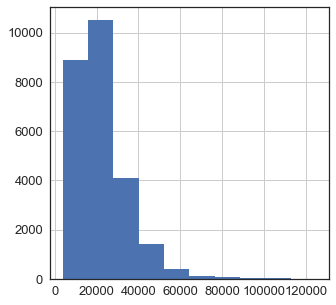

In [298]:
f, ax = plt.subplots(figsize=(5, 5))
_ = all_data['row_sum'].hist()

The overall row sum is skewed heavily to the right. The sum of the entire vector is a fairly abstract measure, but it looks like it will be close to a normal distribution after a log transformation... which makes sense since the data is derived from natural phenomena.

Histogram of log-transformed row sums:

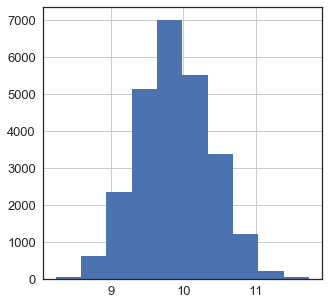

In [299]:
# Let's see if that assumption holds up...
f, ax = plt.subplots(figsize=(5, 5))
_ = all_data['row_sum'].apply(np.log).hist()

Anderson-Darling normalcy test results:

In [300]:
# The data certainly looks normally distributed,
# so I did a quick test of its normality:
x = all_data['row_sum']
anderson_results = sp.stats.anderson(x)

matrix_ad = [
    ['', 'DF', 'Test Statistic', 'p-value'],
    ['Sample Data', len(x) - 1, anderson_results[0], anderson_results[1][2]]]

anderson_table = ff.create_table(matrix_ad, index=True)
py.iplot(anderson_table, filename='anderson-table')

With a p-value much larger than 0.05 it is safe to say that I should not reject my null hypothesis that the data is sampled from a normally distributed population.

**Conclusion:** The majority of users are drawing circles in approximately 'similar' ways, whereas there are roughly equivalent portions of the user base who press softer/harder, draw slower/faster, are particularly accurate/innacurate, have uniquely sized fingers, or some combination of the latter factors.

#### How about the event data?

Rows lacking event data:

In [301]:
all_data['events_sum'] = all_data.loc[:, 'events1':'events10'].sum(axis=1)
check_condition(all_data, 'events_sum', '=', 0)

ID   error1   error2   error3   error4   error5   error6  error7  \
560     bingu   5.0049   9.1322  10.7638   1.6769   7.3432  13.5485  8.2956   
561     bingu   1.3803   6.3102   4.4874   2.8205   3.4025   0.4734  4.3855   
...       ...      ...      ...      ...      ...      ...      ...     ...   
25218  venkat   9.8067   4.7809  10.0976   4.2475   6.7093   4.2181  6.5627   
25219  venkat  16.6830  13.0223  10.8773  18.8882  13.6008   3.1050  7.9850   

        error8   error9  error10    speedx1   speedy1    speedx2    speedy2  \
560     1.6900   1.5770   2.2539   727.3683  103.6964   533.3460   345.2550   
561     8.4756  10.3191   8.0524   730.2728   84.6184   929.0465   706.1653   
...        ...      ...      ...        ...       ...        ...        ...   
25218   6.4696   4.6431  10.6726  1148.3663   46.4875  1874.6022  1193.7500   
25219  13.9481   9.5797   5.5438  2238.0256  127.2679  2132.5779   860.7999   

         speedx3    speedy3   speedx4    speedy4    speedx5    speedy5  \
560     175.2599   491.4319  494.6989   922.7335   719.3231   255.4205   
561     148.3215   704.2418  239.3609   672.3206   465.3942   351.9047   
...          ...        ...       ...        ...        ...        ...   
25218   175.8896  1197.6013  720.7203  1260.8414   760.6467  1018.8738   
25219  1422.4540  1813.7026  843.8496  2348.0996  3048.1660  1405.6798   

         speedx6   speedy6    speedx7   speedy7   speedx8    speedy8  \
560     707.2753   18.8227   847.4709  354.2404  250.1078   920.4377   
561    1017.0928   69.9274   756.0769  704.0549  181.1561   813.2234   
...          ...       ...        ...       ...       ...        ...   
25218  1992.3455  414.0421  1170.0673  966.3002  580.2224  1229.8771   
25219  2052.6387  200.5564   961.8802  964.3723  649.6918   910.9757   

        speedx9    speedy9   speedx10   speedy10  pres1     ...      pres6  \
560    313.6491  1129.8134   714.9126   399.3629    1.0     ...        1.0   
561    237.6222   657.0734   454.6714   369.9111    1.0     ...        1.0   
...         ...        ...        ...        ...    ...     ...        ...   
25218  153.9219  1130.2218  1158.9849   928.6771    1.0     ...        1.0   
25219  392.2200  2407.4563  2311.0493  1337.2582    1.0     ...        1.0   

       pres7  pres8  pres9  pres10  events1  events2  events3  events4  \
560      1.0    1.0    1.0     1.0      0.0      0.0      0.0      0.0   
561      1.0    1.0    1.0     1.0      0.0      0.0      0.0      0.0   
...      ...    ...    ...     ...      ...      ...      ...      ...   
25218    1.0    1.0    1.0     1.0      0.0      0.0      0.0      0.0   
25219    1.0    1.0    1.0     1.0      0.0      0.0      0.0      0.0   

       events5  events6  events7  events8  events9  events10   eStart  \
560        0.0      0.0      0.0      0.0      0.0       0.0  13.2543   
561        0.0      0.0      0.0      0.0      0.0       0.0  17.0903   
...        ...      ...      ...      ...      ...       ...      ...   
25218      0.0      0.0      0.0      0.0      0.0       0.0   4.7812   
25219      0.0      0.0      0.0      0.0      0.0       0.0  33.1932   

       eCenter  direction  timediff  eRadius     orient1     orient2  \
560     5.9677       -1.0    0.0144   5.6667   85.053039   85.093163   
561     7.6129       -1.0    0.0140   2.6667   87.226477   87.096385   
...        ...        ...       ...      ...         ...         ...   
25218   5.7261        1.0    0.0094   1.0000  154.571816  154.801225   
25219  11.4899        1.0    0.0062   3.3333  154.199324  154.199324   

          orient3     orient4     orient5     orient6     orient7     orient8  \
560     84.931073   82.522782   82.911443   83.295902   83.851361   84.754636   
561     86.974932   87.245828   86.327339   87.761024   88.544715   88.238824   
...           ...         ...         ...         ...         ...         ...   
25218  154.801225  157.350657  157.350657  157.056845  157.056845  155.06

#### Although 16% (3984 of the 25540 rows) of the dataset had no event data, I decided to keep them.
- This is because the lack of data for those users will actually serve to distinguish them from others, perhaps lending itself to a clustering by device type (or device group) later on in the analysis.

Event data histogram:

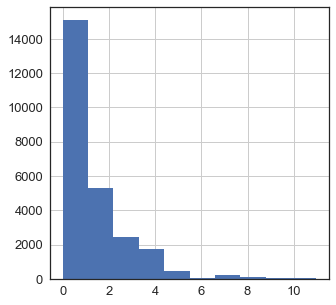

In [302]:
# A histogram will help determine if there are any major outliers:
f, ax = plt.subplots(figsize=(5, 5))
_ = all_data['events_sum'].hist()

**Conclusion:**
The distribution is heavily right-skewed, but the outliers aren't far enough away to be entirely impossible - especially considering that certain device types are recording pressures differently. As such, I will not remove any data, so as to enable better profile differentiation.

#### How about the pressure data?

Rows lacking pressure data:

In [303]:
all_data['pressure_sum'] = all_data.loc[:, 'pres1':'pres10'].sum(axis=1)
check_condition(all_data, 'pressure_sum', '=', 0)

Empty DataFrame
Columns: [ID, error1, error2, error3, error4, error5, error6, error7, error8, error9, error10, speedx1, speedy1, speedx2, speedy2, speedx3, speedy3, speedx4, speedy4, speedx5, speedy5, speedx6, speedy6, speedx7, speedy7, speedx8, speedy8, speedx9, speedy9, speedx10, speedy10, pres1, pres2, pres3, pres4, pres5, pres6, pres7, pres8, pres9, pres10, events1, events2, events3, events4, events5, events6, events7, events8, events9, events10, eStart, eCenter, direction, timediff, eRadius, orient1, orient2, orient3, orient4, orient5, orient6, orient7, orient8, orient9, orient10, row_sum, events_sum, pressure_sum]
Index: []

[0 rows x 69 columns]

Ok, no rows with no pressure data at all, but Morshed told me that most devices recorded pressures between 0 and 1, and visual inspection led me to believe that many devices were recording full pressure across the board. 

Rows with maximum pressure data (pressure data sum = 10):

In [304]:
# If that was the case, pressure_sum would equal 10:
check_condition(all_data, 'pressure_sum', '=', 10)

ID   error1   error2   error3   error4   error5   error6  \
80     amitkumar  11.5297  23.4215  30.8069  13.0880   5.6611   5.2016   
81     amitkumar  18.3408  13.2640  14.3600   1.6662  16.3604  20.2276   
...          ...      ...      ...      ...      ...      ...      ...   
25618       yash   2.7774   5.2016   3.1677   3.4026   4.0612   4.9261   
25619       yash   7.4954   8.6074   6.6410  11.0307  11.8608  17.2440   

        error7   error8   error9  error10    speedx1   speedy1    speedx2  \
80     19.3908   8.0333  10.3610   1.5207  1298.8934  222.1235  1630.2574   
81      9.7411  19.0295  19.6060  19.7476  1219.1433  132.2379   790.9468   
...        ...      ...      ...      ...        ...       ...        ...   
25618   6.4674   9.9509  13.1695   9.0676   907.8414  208.2512  1178.1390   
25619  11.8209   6.1614   9.4381   1.9363  1054.4751   75.6858  1057.2577   

        speedy2   speedx3    speedy3    speedx4    speedy4    speedx5  \
80     491.6219  276.3807  1156.0313  1200.2944  1718.1431  1046.4871   
81     385.8278  196.2621   954.6773   415.7989   556.2344  1154.0093   
...         ...       ...        ...        ...        ...        ...   
25618  611.7087   76.2177  1026.2959   178.7322  1150.4247   887.2474   
25619  608.5671   84.2617  1149.4867   329.7043  1346.4938  1079.4761   

        speedy5    speedx6   speedy6    speedx7    speedy7   speedx8  \
80     728.2542   990.3608  569.2036  1202.0690  1026.2802  289.7458   
81     807.7946  1410.5531   60.1569   953.5333   480.3615  195.0391   
...         ...        ...       ...        ...        ...       ...   
25618  892.5502   639.9847  234.0834   832.7302   407.0190  266.5035   
25619  823.5077  1530.5177   97.9240  1362.8774   672.1523  163.4051   

         speedy8   speedx9    speedy9   speedx10  speedy10  pres1  \
80      336.7869  236.5773  1208.2634   582.5721  662.4467    1.0   
81     1325.3217  448.0513   895.7092  1084.4845  619.9097    1.0   
...          ...       ...        ...        ...       ...    ...   
25618  1132.4095  364.9814  1209.6935   643.1867  646.0056    1.0   
25619  1215.3186  307.5812  1541.2584   772.7090  857.2230    1.0   

           ...       pres7  pres8  pres9  pres10  events1  events2  events3  \
80         ...         1.0    1.0    1.0     1.0   0.0392   0.0392   0.0392   
81         ...         1.0    1.0    1.0     1.0   0.0392   0.0392   0.0392   
...        ...         ...    ...    ...     ...      ...      ...      ...   
25618      ...         1.0    1.0    1.0     1.0   0.0471   0.0471   0.0471   
25619      ...         1.0    1.0    1.0     1.0   0.0353   0.0353   0.0353   

       events4  events5  events6  events7  events8  events9  events10  \
80      0.0392   0.0392   0.0392   0.0392   0.0392   0.0392    0.0392   
81      0.0392   0.0392   0.0392   0.0392   0.0392   0.0392    0.0392   
...        ...      ...      ...      ...      ...      ...       ...   
25618   0.0471   0.0471   0.0471   0.0471   0.0471   0.0471    0.0471   
25619   0.0353   0.0353   0.0353   0.0353   0.0353   0.0353    0.0353   

        eStart  eCenter  direction  timediff  eRadius    orient1    orient2  \
80      8.8922  13.9357        1.0    0.0099      5.5  335.93981  335.93981   
81      5.9136  12.2699       -1.0    0.0122     16.5  338.15549  338.15549   
...        ...      ...        ...       ...      ...        ...        ...   
25618  12.8940   5.0836        1.0    0.0129      3.5    0.00000    0.00000   
25619   1.8326  11.9772        1.0    0.0117     12.5    0.00000    0.00000   

          orient3     orient4     orient5     orient6     orient7     orient8  \
80     336.117529  336.117529  336.243401  336.243401  335.534954  336.934679   
81     338.185708  338.223111  338.113826  338.113826  338.646825  338.646825   
...           ...         ...         ...         ...         ...         ...   
25618    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25619    0.000000    0.00

Rows without maximum pressure data (0 < pressure data sum < 10):

In [305]:
# The majority of the remaining ~43% are between 0 and 10:
check_condition(all_data, 'pressure_sum', '<', 10)

ID   error1   error2   error3  error4   error5   error6  \
0      A3MC5OA9RXOOFH   5.2326   3.7874   2.4150  6.7158  11.3644  19.8435   
1      A3MC5OA9RXOOFH   3.3471  10.8631  13.3662  2.5906  10.8540  10.3874   
...               ...      ...      ...      ...     ...      ...      ...   
25418         wws1985   2.2866   2.9053   0.7132  0.3544   4.7496   0.3922   
25419         wws1985  14.5151  13.0089   6.5503  1.7357  14.5307  11.1541   

        error7   error8  error9  error10    speedx1   speedy1    speedx2  \
0       3.9390   3.5785  3.8274  16.0181  1628.3192  585.6036  1107.0507   
1      14.4925  11.3582  4.8619  10.0893     0.0000    0.0000  1467.2589   
...        ...      ...     ...      ...        ...       ...        ...   
25418   3.4965   2.3631  1.0754   3.0013   701.7535   22.1583  1733.5336   
25419   4.6152   0.2547  7.5181  15.5188  1174.5687   55.5445  1326.9009   

         speedy2   speedx3    speedy3   speedx4    speedy4    speedx5  \
0       609.4896   26.2030  1336.8486  266.2498   877.8011  2832.5134   
1      1406.2163  615.0792  1633.1307  139.4056   950.7105   955.6737   
...          ...       ...        ...       ...        ...        ...   
25418   943.1631  229.0571   589.0761  238.6884   405.1342   860.7718   
25419   724.9291  469.6471  1091.1268   73.6426  1040.8492   443.9335   

        speedy5    speedx6   speedy6    speedx7    speedy7    speedx8  \
0      507.1425  2045.1091  269.0751  1152.0160   838.2979   528.1893   
1      761.0110  1348.4182  142.2386  1429.7231  1036.2416  1065.8569   
...         ...        ...       ...        ...        ...        ...   
25418  616.3697   913.3693   41.3095   384.8360   459.1874   264.8267   
25419  310.1054   971.2195   72.0744   490.5255   613.1284   233.0836   

         speedy8   speedx9    speedy9   speedx10   speedy10   pres1  \
0      1343.5573  292.7176  1706.5969   952.1872  1176.6602  0.1765   
1      1481.4324  766.5814  1517.1062  1344.4899  1262.9180  0.1725   
...          ...       ...        ...        ...        ...     ...   
25418   965.6447  217.3920   704.9470   851.0185   435.1353  0.2039   
25419  1644.6128  425.4972  1043.0587   971.8193   736.8627  0.2078   

           ...        pres7   pres8   pres9  pres10  events1  events2  \
0          ...       0.1765  0.1922  0.1725  0.1725   0.2000   0.1667   
1          ...       0.1765  0.1765  0.1725  0.1765   0.1333   0.1333   
...        ...          ...     ...     ...     ...      ...      ...   
25418      ...       0.2118  0.2118  0.2118  0.2078   0.2667   0.1333   
25419      ...       0.2000  0.2078  0.2078  0.2078   0.3000   0.2667   

       events3  events4  events5  events6  events7  events8  events9  \
0       0.1667   0.1333   0.1333   0.1667   0.1667   0.2000   0.1333   
1       0.1667   0.1333   0.1333   0.2000   0.1667   0.1667   0.1667   
...        ...      ...      ...      ...      ...      ...      ...   
25418   0.3333   0.3000   0.3000   0.3000   0.3000   0.3333   0.3333   
25419   0.2667   0.3000   0.3000   0.3000   0.3000   0.3333   0.3000   

       events10   eStart  eCenter  direction  timediff  eRadius     orient1  \
0        0.1667   4.8165   4.0095        1.0    0.0096   1.5000  275.002801   
1        0.1667  10.2043   6.3384        1.0    0.0085   8.5000  270.541039   
...         ...      ...      ...        ...       ...      ...         ...   
25418    0.3333   8.0845   1.8165       -1.0    0.0133   0.0000  181.581045   
25419    0.3000  10.2262  20.5750        1.0    0.0109   3.9216  181.630240   

          orient2     orient3     orient4     orient5     orient6     orient7  \
0      269.988390  269.988390  275.931421  272.893113  272.893113  275.265742   
1      275.229524  274.201104  274.201104  275.420969  274.964373  274.964373   
...           ...         ...         ...         ...         ...         ...   
25418  181.580050  181.676100  181.674481  181.690478  181.645009  181.642839   
25419  181.690607  181.721907  181.7

Rows with greater than maximum pressure data (pressure data sum > 10):

In [306]:
# Leaving only 13 rows over 10:
check_condition(all_data, 'pressure_sum', '>', 10)

ID  error1   error2   error3   error4   error5  error6   error7  \
2650   indreesh  1.3865   5.0064   4.4429   5.6320  10.8997  3.7716  13.6691   
2658   indreesh  1.9608  15.7290  13.9492  12.4821   4.0274  1.1765   1.8240   
...         ...     ...      ...      ...      ...      ...     ...      ...   
14029  indreesh  3.8920   0.1151   6.4122  11.9321   2.4150  5.1803   6.1695   
14032  indreesh  3.1003   3.9307   2.5597   7.7612   0.9428  2.4802   1.5050   

       error8  error9  error10    speedx1   speedy1    speedx2    speedy2  \
2650   3.7021  0.3349   3.8715  1036.0216    0.0037   710.4830   476.7417   
2658   0.9968  1.4013   6.7769  1576.2517  759.0020  1080.7969  1114.9509   
...       ...     ...      ...        ...       ...        ...        ...   
14029  0.8434  2.4957   2.7702  1256.9639   65.4692   897.6270   467.0536   
14032  2.3068  3.3267   2.6989  1028.6952   61.7308   861.8290   491.5651   

        speedx3    speedy3   speedx4    speedy4    speedx5   speedy5  \
2650   240.4868   915.5864  112.9243   647.2947   524.8779  393.5064   
2658   823.4908  1358.5415  957.0336  1561.4231  1164.5509  675.1423   
...         ...        ...       ...        ...        ...       ...   
14029  198.8226  1024.2200   50.5403   883.5867  1083.5094  362.3131   
14032    1.8283   929.8763  434.6848  1203.2429   543.5209  571.0049   

         speedx6  speedy6   speedx7   speedy7   speedx8    speedy8   speedx9  \
2650   1281.2212   1.7284  646.2264  414.6959  100.2464   803.1724  250.0837   
2658    967.8410   3.7378  778.7504  501.7126  415.9243  1160.6986  559.7400   
...          ...      ...       ...       ...       ...        ...       ...   
14029   908.8830  92.6314  950.7864  517.2324  272.9971   813.7673  347.9412   
14032  1379.9581  66.1531  793.4568  693.5878  390.9486   982.5697  264.6526   

         speedy9   speedx10   speedy10   pres1      ...        pres7   pres8  \
2650    858.6498   656.5092   490.7835  1.0250      ...       1.0250  1.0250   
2658   1326.3271  1819.1022  1240.6931  1.0375      ...       1.0375  1.0375   
...          ...        ...        ...     ...      ...          ...     ...   
14029  1052.7240  1031.8425   816.3212  0.6500      ...       1.1875  0.9250   
14032  1047.2458   905.1312   604.7917  1.0250      ...       1.0250  1.0250   

        pres9  pres10  events1  events2  events3  events4  events5  events6  \
2650   1.0250  1.0250   0.0353   0.0314   0.0314   0.0353   0.0314   0.0392   
2658   1.0375  1.0375   0.0392   0.0275   0.0353   0.0353   0.0353   0.0392   
...       ...     ...      ...      ...      ...      ...      ...      ...   
14029  0.9250  0.9250   0.0235   0.0275   0.0353   0.0353   0.0392   0.0510   
14032  1.0250  1.0250   0.0314   0.0275   0.0314   0.0275   0.0314   0.0431   

       events7  events8  events9  events10   eStart  eCenter  direction  \
2650    0.0392   0.0353   0.0353    0.0235  12.5122   4.2663        1.0   
2658    0.0392   0.0353   0.0431    0.0353  23.5849   2.9601        1.0   
...        ...      ...      ...       ...      ...      ...        ...   
14029   0.0510   0.0392   0.0314    0.0353   7.4510   4.5872        1.0   
14032   0.0392   0.0314   0.0353    0.0275  15.8083   2.8161        1.0   

       timediff  eRadius     orient1     orient2     orient3     orient4  \
2650     0.0144   3.0503  331.572013  333.529609  333.612050  330.868554   
2658     0.0082   4.7140  327.818547  328.746103  328.813017  326.180931   
...         ...      ...         ...         ...         ...         ...   
14029    0.0115   1.1092   55.226805   54.561891   54.405882   54.708317   
14032    0.0110   0.2773   55.326305   55.317267   54.671748   55.317267   

          orient5     orient6     orient7     orient8     orient9    orient10  \
2650   329.019756  323.921287  323.935179  324.756832  325.571805  327.545417   
2658   326.180931  325.282954  324.289994  325.015384  324.021604  327.818547   
...           ...         ...         ...       

Pressure data histogram:

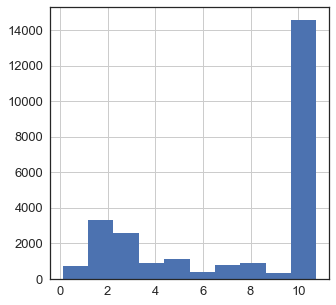

In [307]:
f, ax = plt.subplots(figsize=(5, 5))
_ = all_data['pressure_sum'].hist()

#### So the entire dataset can be split into three major groups:
 - ~57% (14514 / 25540) recorded maximum pressure at every point (summing to exactly 10).
 - ~43% (11013 / 25540) recorded pressures that sum to less than 10.
 - Two users, accounting for ~0.0005% of the data, who recorded pressures that sum to a number over 10. This is most likely due to differences in device type.
 
**Conclusion:**
Despite the pressure data not being as nuanced as it could be, I feel that this will help to disperse users within the feature space.

In [308]:
# Drop the analysis columns:
all_data = all_data.drop(columns=['row_sum','events_sum','pressure_sum'])

### Next, I explored the correlations amongst all 65 features

Text(0.5,1,'Feature Correlation Heatmap')

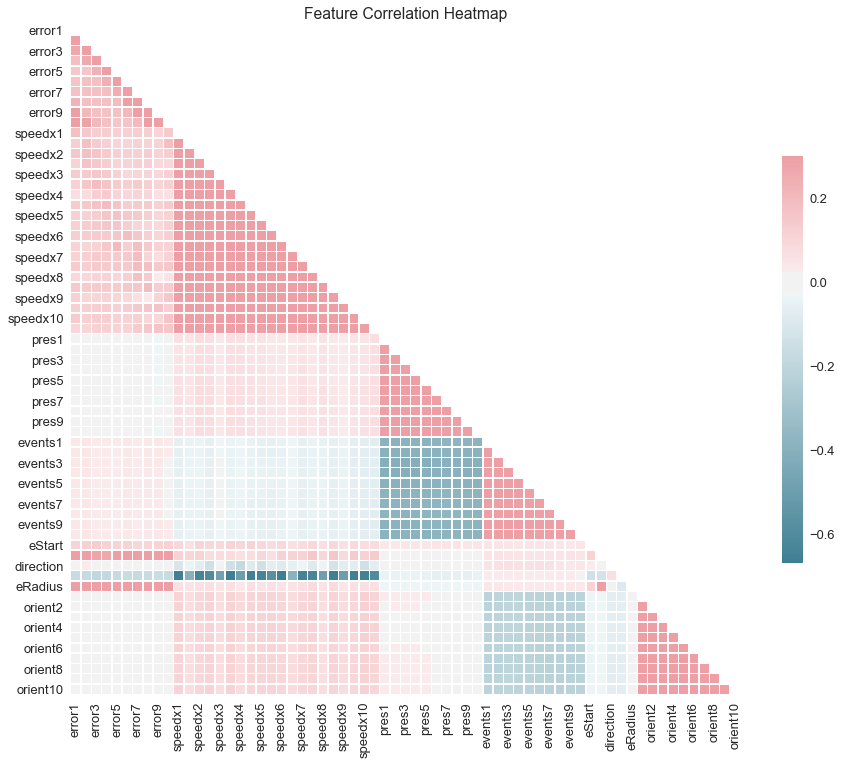

In [309]:
# Reference: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Compute the correlation matrix
corr = all_data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(style='white', color_codes=True, font_scale=1.3)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Feature Correlation Heatmap')

#### The feature correlation heatmap indicates that each feature group is more strongly correlated with itself than with other feature groups.

Next I determined which features had the most and least amount of total correlation relative to all other features. I think that this statistic will give some indication of which features are more or less independent than others.

In [310]:
# Calculate the sum of all correlations for each feature:
row_sums = []
for index, row in corr.iterrows():
    row_sum = sum([abs(x) for x in row])
    row_sums.append(row_sum)

corr['row_sum'] = row_sums

**5 features with the least amount of Total Correlation:**

In [311]:
list(corr.sort_values('row_sum').index[:5])

['direction', 'eStart', 'error5', 'eRadius', 'error4']

These are the most independent features.

**5 features with the most amount of Total Correlation:**

In [312]:
list(corr.sort_values('row_sum').index[-5:])

['speedy3', 'speedx10', 'speedy8', 'speedy4', 'speedx1']

These are the most dependent features.

### Next I decided to experiment with removing outliers
 - Here I define outliers as rows in the dataset having a value for at least one feature which is over 4 standard deviations from the mean value for that feature.
 - I also compared the results using the definition above with results from using a threshold of 3 standard deviations.

**Using a threshold of 3 standard deviations:**

In [313]:
# Remove all rows that have an outlier in at least one column:
all_data_no_outliers1 = all_data[(np.abs(sp.stats.zscore(all_data.drop(columns='ID'))) < 3).all(axis=1)]

# Quantify the magnitude of data removal:
print("Original # of records:", len(all_data))
print("After outlier removal:", len(all_data_no_outliers1))
print("Percentage removed:", round(((len(all_data) - 
                                     len(all_data_no_outliers1)) / len(all_data)),2))

Original # of records: 25540
After outlier removal: 19971
Percentage removed: 0.22


**Using a threshold of 4 standard deviations:**

In [314]:
all_data_no_outliers2 = all_data[(np.abs(sp.stats.zscore(all_data.drop(columns='ID'))) < 4).all(axis=1)]
print("Original # of records:", len(all_data))
print("After outlier removal:", len(all_data_no_outliers2))
print("Percentage removed:", round(((len(all_data) - 
                                     len(all_data_no_outliers2)) / len(all_data)),2))

Original # of records: 25540
After outlier removal: 23033
Percentage removed: 0.1


So, 22% of the vectors in the dataset have at least one value which lies over 3 standard deviations from its mean. And 10% of the vectors have at least one value which lies over 4 standard deviations from its mean.

In [315]:
# Define a function for assessing the impact of outlier removal on feature means:
def compare_means(df1, df2):
    # Obtain lists of column means for original and filtered data:
    df1_means = [(x, df1[x].mean()) for x in df1.columns[1:]]
    df2_means = [df2[x].mean() for x in df2.columns[1:]]

    # Combine them into one dataframe:
    means1 = pd.DataFrame(data=df1_means)
    means2 = pd.DataFrame(data=df2_means)
    means = pd.concat([means1, means2], axis=1)
    means.columns = ['column_name','orig_mean','filtered_mean']

    # Calculate the real difference between means after filtering,
    # and as a percentage of the original mean:
    means['diff'] = means['orig_mean'] - means['filtered_mean']
    means['pct_diff'] = abs(means['diff'] / means['orig_mean'])
    means = means.sort_values(by='pct_diff', ascending=False)
    display(means)

**Effect on feature means when using 3 standard deviations:**

In [316]:
compare_means(all_data, all_data_no_outliers1)

column_name   orig_mean  filtered_mean       diff   pct_diff
52   direction   -0.002114       0.022683  -0.024797  11.728167
21     speedy6  219.213793     170.563853  48.649941   0.221929
..         ...         ...            ...        ...        ...
61     orient7  173.907711     173.575338   0.332373   0.001911
62     orient8  173.973979     173.643111   0.330868   0.001902

[65 rows x 5 columns]

When removing data based on 3 standard deviations, the means of all 65 features shifted by a maximum of a 11.7% - with 64/65 having shifted by less than 0.22%.

**Effect on feature means when using 4 standard deviations:**

In [317]:
compare_means(all_data, all_data_no_outliers2)

column_name   orig_mean  filtered_mean       diff  pct_diff
52   direction   -0.002114       0.010984  -0.013099  6.195139
21     speedy6  219.213793     189.597212  29.616581  0.135104
..         ...         ...            ...        ...       ...
58     orient4  172.942458     173.278101  -0.335643  0.001941
57     orient3  172.986905     173.289692  -0.302787  0.001750

[65 rows x 5 columns]

When removing data based on 4 standard deviations, the means of all 65 features shifted by a maximum of a 6.2% - the other 64/65 having shifted by less than 0.14% - meaning that filtering the data had very little impact. So I will proceed with the original data, keeping the tail of each feature's distribution intact.


### Comparison of summary statistics for each feature
 - I decided to focus on mean, standard deviation, and range (max - min) for each feature.
 - The difference in units between features makes plotting them all together relatively useless, so I chose to drill in by feature group. During my analysis I will circumvent this problem by normalizing all values into a single range.

In [318]:
# Collate summary statistics for each feature into one data frame:
summary_statistics_list = [(all_data[col].mean(),
                            all_data[col].std(), 
                            (all_data[col].max() - all_data[col].min())) 
                           for col in all_data.columns[1:]]
summary_statistics = pd.DataFrame(summary_statistics_list, 
                                  columns=['Mean', 'Standard Deviation', 'Range'],
                                  index=all_data.columns[1:])

#### Error Summary Statistics

[Text(0.5,0,'Feature'), Text(0.5,1,'Error Ranges')]

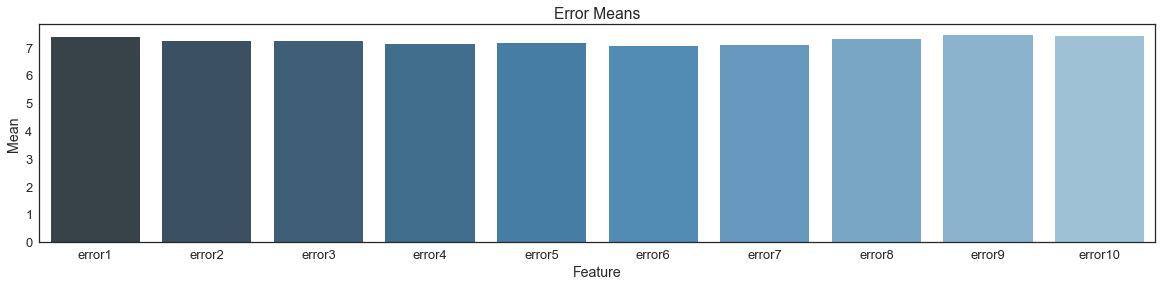

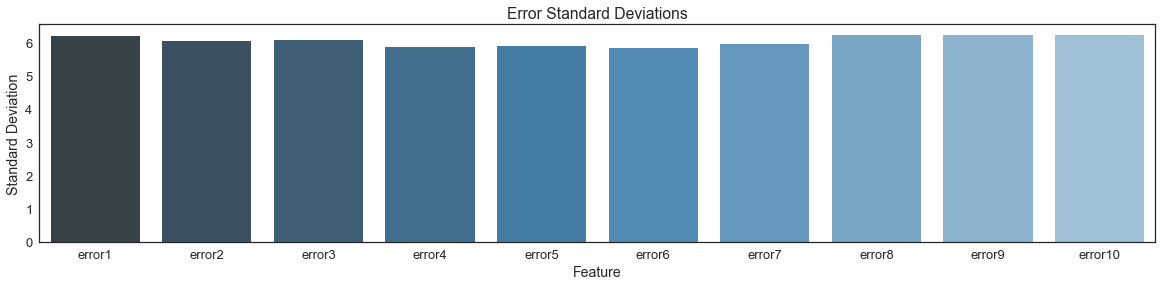

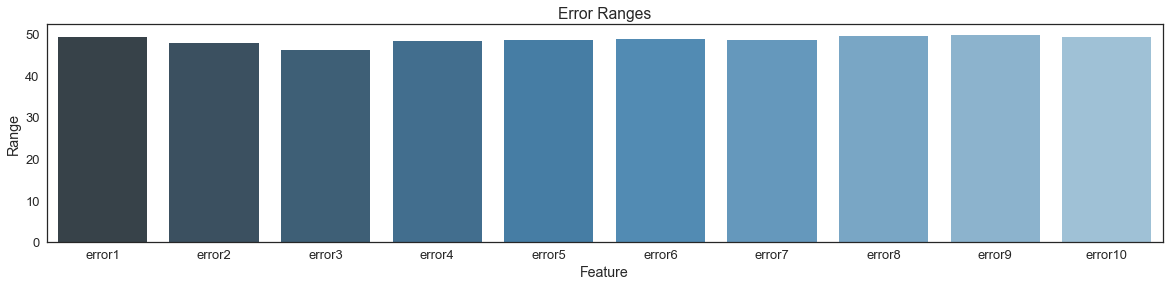

In [319]:
# Plot means, standard deviations, and ranges:
f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[:10],
                y=summary_statistics['Mean'][:10], palette='Blues_d')
ax.set(xlabel='Feature', title='Error Means')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[:10], 
                y=summary_statistics['Standard Deviation'][:10], palette='Blues_d')
ax.set(xlabel='Feature', title='Error Standard Deviations')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[:10], 
                y=summary_statistics['Range'][:10], palette='Blues_d')
ax.set(xlabel='Feature', title='Error Ranges')

The mean error, standard deviation of error, and range of error are all fairly static across the 10 measurement points. Therefore users must deviate from the ideal circle by roughly equal amounts at all 10 points.

#### Speed Summary Statistics

[Text(0.5,0,'Feature'), Text(0.5,1,'Speed y coordinate means')]

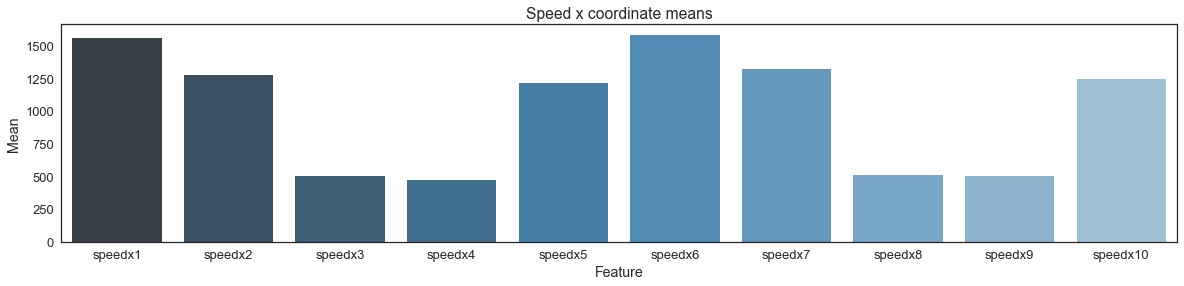

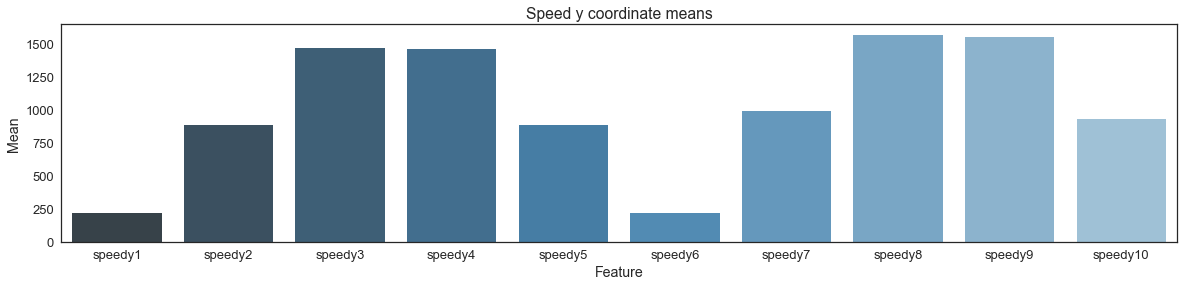

In [320]:
# Plot the x & y coordinate means:
f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[10:30:2], 
                y=summary_statistics['Mean'][10:30:2], palette='Blues_d')
ax.set(xlabel='Feature', title='Speed x coordinate means')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[11:30:2], 
                y=summary_statistics['Mean'][11:30:2], palette='Blues_d')
ax.set(xlabel='Feature', title='Speed y coordinate means')

The mean speed values in the x and y directions are roughly inverse to one another at each point. That is exactly what I would expect, given that the users are attempting to draw perfect circles. This is because point 1 is located at the top of the circle, with the remaining points spread out around the circumference. So high lateral (x) speed is registered across the top and bottom of each circle, while high vertical (y) speed is registered along each side.

[Text(0.5,0,'Feature'), Text(0.5,1,'Speed y coordinate standard deviations')]

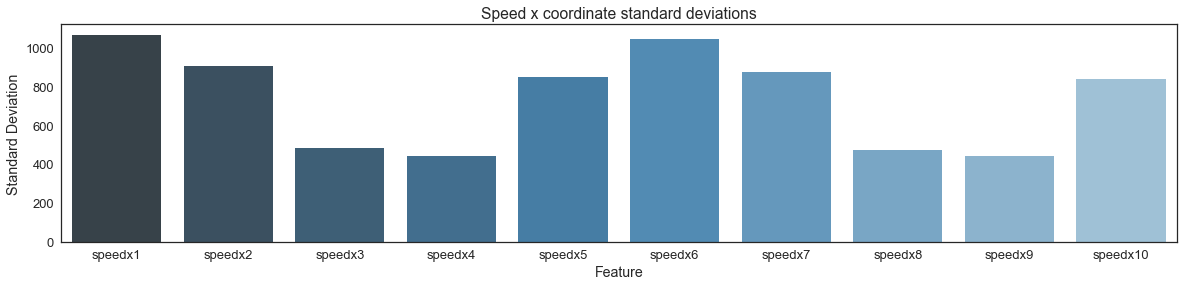

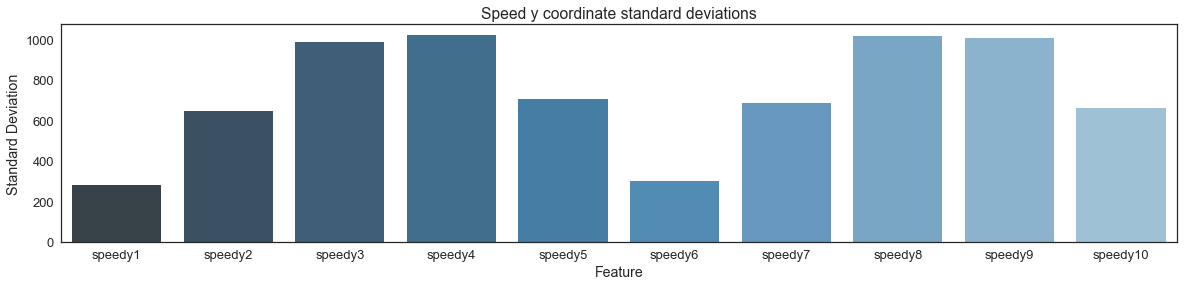

In [321]:
# Plot the standard deviations
f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[10:30:2], 
                y=summary_statistics['Standard Deviation'][10:30:2], palette='Blues_d')
ax.set(xlabel='Feature', title='Speed x coordinate standard deviations')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[11:30:2], 
                y=summary_statistics['Standard Deviation'][11:30:2], palette='Blues_d')
ax.set(xlabel='Feature', title='Speed y coordinate standard deviations')

The standard deviation of speed values in the x and y directions are also roughly inverse to one another at each point. It also makes sense that standard deviation would increase in tandem with speed.

[Text(0.5,0,'Feature'), Text(0.5,1,'Speed y coordinate ranges')]

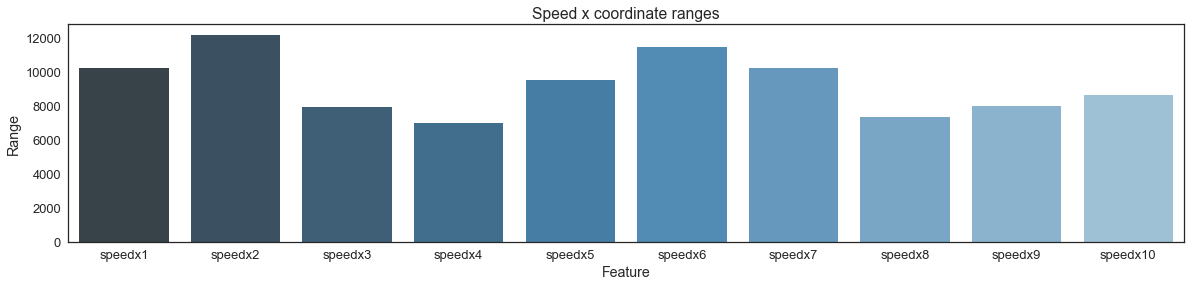

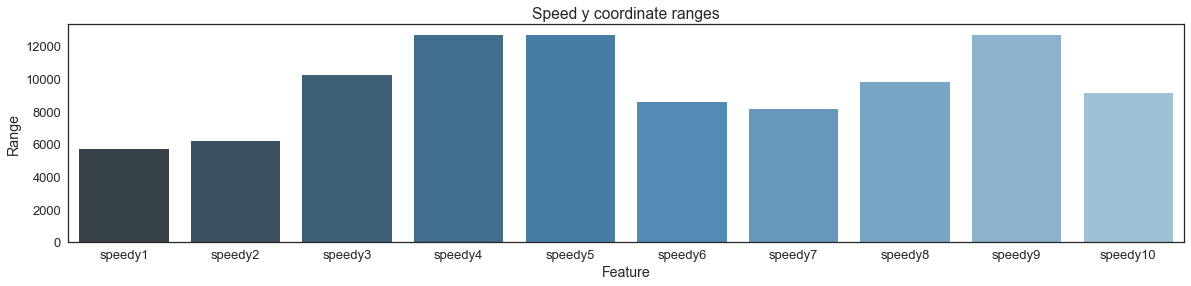

In [322]:
# Plot the ranges
f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[10:30:2], 
                y=summary_statistics['Range'][10:30:2], palette='Blues_d')
ax.set(xlabel='Feature', title='Speed x coordinate ranges')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[11:30:2], 
                y=summary_statistics['Range'][11:30:2], palette='Blues_d')
ax.set(xlabel='Feature', title='Speed y coordinate ranges')

The range of values for the x and y components of drawing speed across the 10 points are distributed similarly to the means and standard deviations, but with a less stark inverse relationship.

#### Pressure Summary Statistics

[Text(0.5,0,'Feature'), Text(0.5,1,'Pressure Ranges')]

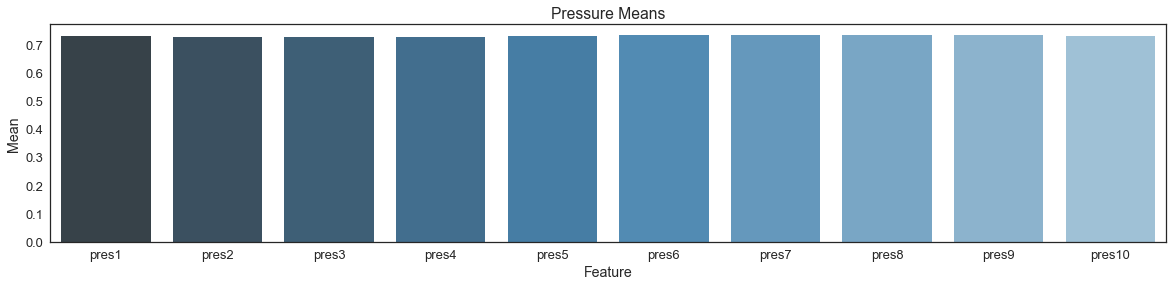

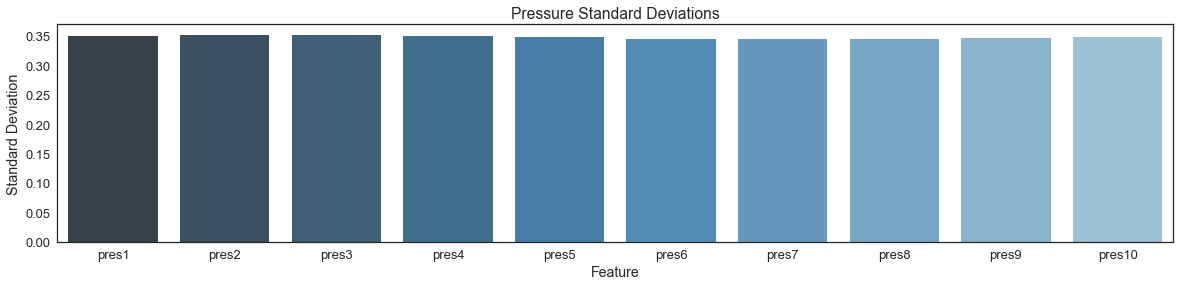

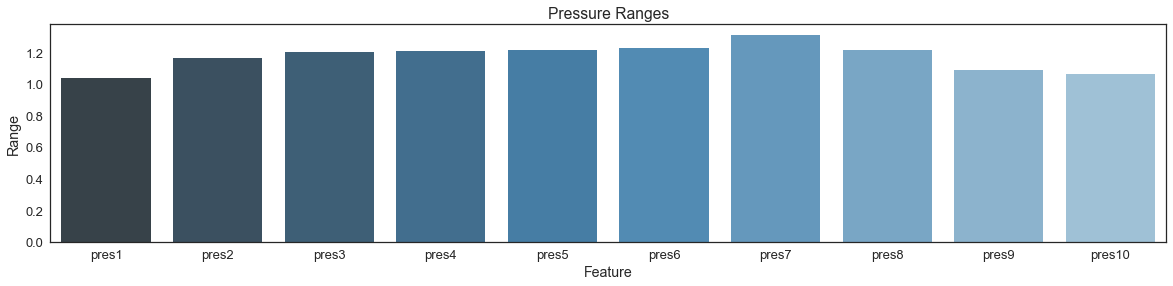

In [323]:
f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[30:40], 
                y=summary_statistics['Mean'][30:40], palette='Blues_d')
ax.set(xlabel='Feature', title='Pressure Means')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[30:40], 
                y=summary_statistics['Standard Deviation'][30:40], palette='Blues_d')
ax.set(xlabel='Feature', title='Pressure Standard Deviations')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[30:40], 
                y=summary_statistics['Range'][30:40], palette='Blues_d')
ax.set(xlabel='Feature', title='Pressure Ranges')

The pressure mean and standard deviation in pressure are very constant across all 10 points. However the range of pressure recordings shows a slight arc - indicating that users are more consistent at the beginning and end of their circles, and less consistent in the middle.

#### Event Summary Statistics

[Text(0.5,0,'Feature'), Text(0.5,1,'Event Ranges')]

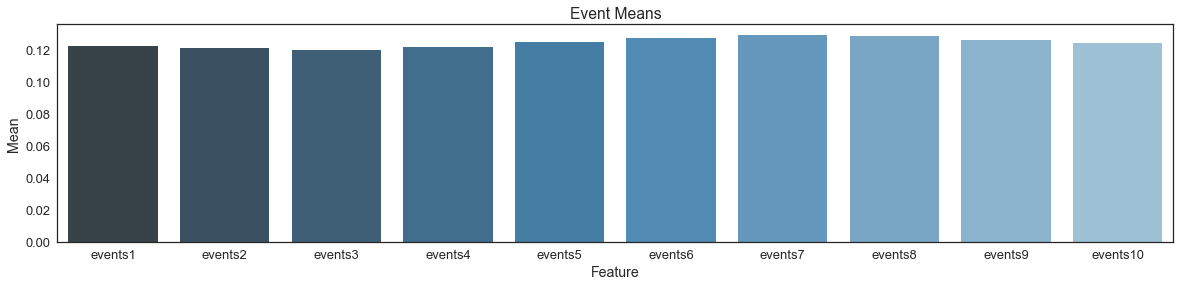

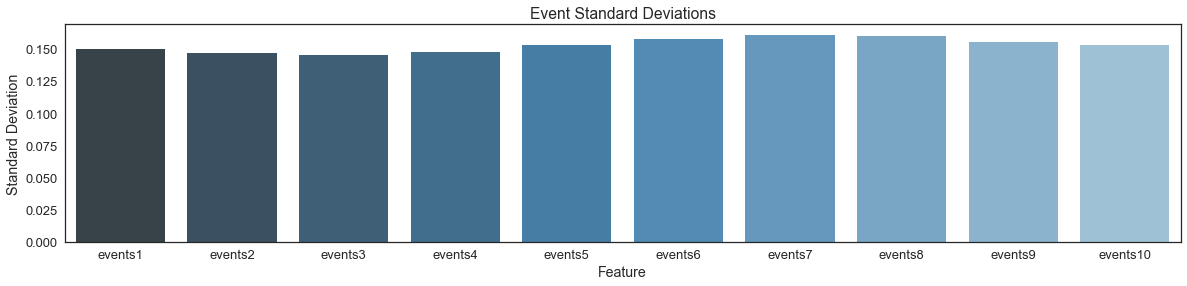

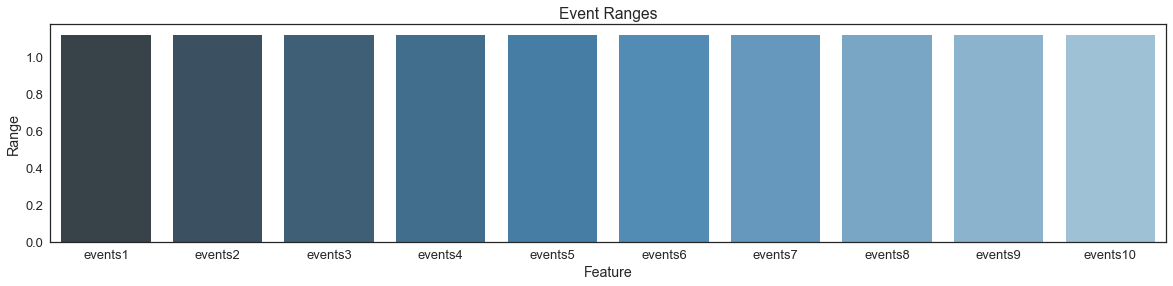

In [324]:
f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[40:50], 
                y=summary_statistics['Mean'][40:50], palette='Blues_d')
ax.set(xlabel='Feature', title='Event Means')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[40:50], 
                y=summary_statistics['Standard Deviation'][40:50], palette='Blues_d')
ax.set(xlabel='Feature', title='Event Standard Deviations')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[40:50], 
                y=summary_statistics['Range'][40:50], palette='Blues_d')
ax.set(xlabel='Feature', title='Event Ranges')

Like error data, event data shows very little variance across the 10 measurement points. This makes a lot of sense intuitively, because the size of user's finger & hence contact surface area should remain quite static.

#### Orientation Summary Statistics

[Text(0.5,0,'Feature'), Text(0.5,1,'Orientation Ranges')]

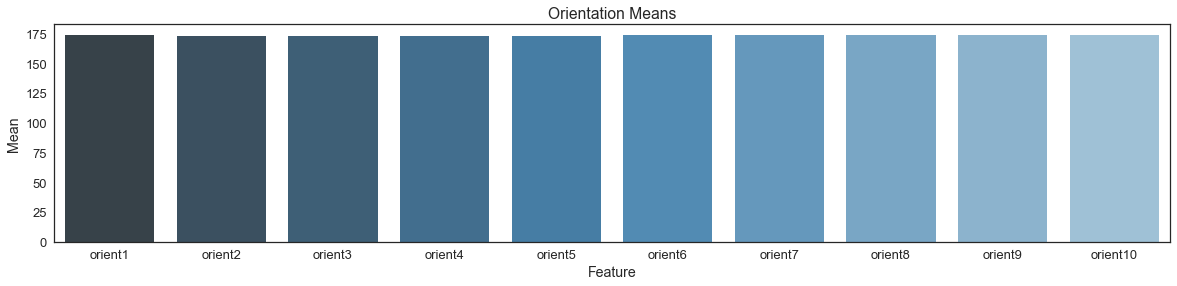

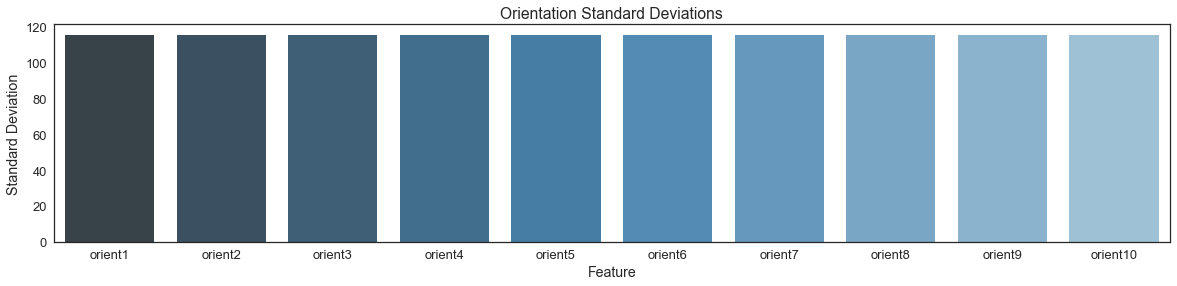

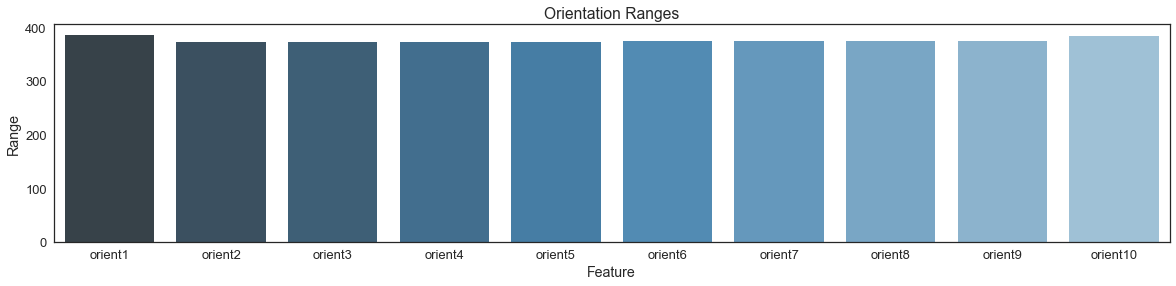

In [325]:
f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[55:65], 
                y=summary_statistics['Mean'][55:65], palette='Blues_d')
ax.set(xlabel='Feature', title='Orientation Means')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[55:65], 
                y=summary_statistics['Standard Deviation'][55:65], palette='Blues_d')
ax.set(xlabel='Feature', title='Orientation Standard Deviations')

f, ax = plt.subplots(figsize=(20, 4))
_ = sns.barplot(x=summary_statistics.index[55:65], 
                y=summary_statistics['Range'][55:65], palette='Blues_d')
ax.set(xlabel='Feature', title='Orientation Ranges')

The orientation data is also very consistent. Therefore users must tend to hold their phones relatively stable throughout the process of drawing a circle.

#### Analysis & summary statistics for the 5 features not in a feature group

**direction:**

Summary statistics

In [353]:
pd.options.display.max_rows = 10
all_data[['direction']].describe()

direction
count  25540.000000
mean      -0.002114
std        1.000017
min       -1.000000
25%       -1.000000
50%       -1.000000
75%        1.000000
max        1.000000

Since direction is either 1 or -1, I figured I would see how many circles are drawn in each direction...

In [327]:
check_condition(all_data, 'direction', '=', 1)

ID  error1   error2   error3   error4   error5   error6  \
0      A3MC5OA9RXOOFH  5.2326   3.7874   2.4150   6.7158  11.3644  19.8435   
1      A3MC5OA9RXOOFH  3.3471  10.8631  13.3662   2.5906  10.8540  10.3874   
...               ...     ...      ...      ...      ...      ...      ...   
25618            yash  2.7774   5.2016   3.1677   3.4026   4.0612   4.9261   
25619            yash  7.4954   8.6074   6.6410  11.0307  11.8608  17.2440   

        error7   error8   error9  error10    speedx1   speedy1    speedx2  \
0       3.9390   3.5785   3.8274  16.0181  1628.3192  585.6036  1107.0507   
1      14.4925  11.3582   4.8619  10.0893     0.0000    0.0000  1467.2589   
...        ...      ...      ...      ...        ...       ...        ...   
25618   6.4674   9.9509  13.1695   9.0676   907.8414  208.2512  1178.1390   
25619  11.8209   6.1614   9.4381   1.9363  1054.4751   75.6858  1057.2577   

         speedy2   speedx3    speedy3   speedx4    speedy4    speedx5  \
0       609.4896   26.2030  1336.8486  266.2498   877.8011  2832.5134   
1      1406.2163  615.0792  1633.1307  139.4056   950.7105   955.6737   
...          ...       ...        ...       ...        ...        ...   
25618   611.7087   76.2177  1026.2959  178.7322  1150.4247   887.2474   
25619   608.5671   84.2617  1149.4867  329.7043  1346.4938  1079.4761   

        speedy5    speedx6   speedy6    speedx7    speedy7    speedx8  \
0      507.1425  2045.1091  269.0751  1152.0160   838.2979   528.1893   
1      761.0110  1348.4182  142.2386  1429.7231  1036.2416  1065.8569   
...         ...        ...       ...        ...        ...        ...   
25618  892.5502   639.9847  234.0834   832.7302   407.0190   266.5035   
25619  823.5077  1530.5177   97.9240  1362.8774   672.1523   163.4051   

         speedy8   speedx9    speedy9   speedx10   speedy10   pres1  \
0      1343.5573  292.7176  1706.5969   952.1872  1176.6602  0.1765   
1      1481.4324  766.5814  1517.1062  1344.4899  1262.9180  0.1725   
...          ...       ...        ...        ...        ...     ...   
25618  1132.4095  364.9814  1209.6935   643.1867   646.0056  1.0000   
25619  1215.3186  307.5812  1541.2584   772.7090   857.2230  1.0000   

          ...       pres4   pres5   pres6   pres7   pres8   pres9  pres10  \
0         ...      0.1725  0.1725  0.1725  0.1765  0.1922  0.1725  0.1725   
1         ...      0.1725  0.1725  0.1804  0.1765  0.1765  0.1725  0.1765   
...       ...         ...     ...     ...     ...     ...     ...     ...   
25618     ...      1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
25619     ...      1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   

       events1  events2  events3  events4  events5  events6  events7  events8  \
0       0.2000   0.1667   0.1667   0.1333   0.1333   0.1667   0.1667   0.2000   
1       0.1333   0.1333   0.1667   0.1333   0.1333   0.2000   0.1667   0.1667   
...        ...      ...      ...      ...      ...      ...      ...      ...   
25618   0.0471   0.0471   0.0471   0.0471   0.0471   0.0471   0.0471   0.0471   
25619   0.0353   0.0353   0.0353   0.0353   0.0353   0.0353   0.0353   0.0353   

       events9  events10   eStart  eCenter  direction  timediff  eRadius  \
0       0.1333    0.1667   4.8165   4.0095        1.0    0.0096      1.5   
1       0.1667    0.1667  10.2043   6.3384        1.0    0.0085      8.5   
...        ...       ...      ...      ...        ...       ...      ...   
25618   0.0471    0.0471  12.8940   5.0836        1.0    0.0129      3.5   
25619   0.0353    0.0353   1.8326  11.9772        1.0    0.0117     12.5   

          orient1     orient2     orient3     orient4     orient5     orient6  \
0      275.002801  269.988390  269.988390  275.931421  272.893113  272.893113   
1      270.541039  275.229524  274.201104  274.201104  275.420969  274.964373   
...           ...         ...         ...         ...         ...         ...   
25618    0.000000    0.000000    0.000000    0.0000

In [352]:
print('So', round((12743 / 25540)*100,2),'% of the circles were drawn in a clockwise direction.')

So 49.89 % of the circles were drawn in a clockwise direction.


In [329]:
check_condition(all_data, 'direction', '=', -1)

ID  error1   error2  error3   error4   error5   error6  \
2      A3MC5OA9RXOOFH  9.9535   4.4871  7.0042   1.4158   7.7458  11.1133   
3      A3MC5OA9RXOOFH  9.8325  24.6040  2.7769   1.6585   7.1072  17.3278   
...               ...     ...      ...     ...      ...      ...      ...   
25518             Yan  5.1377   1.2930  2.5001   5.6416  13.3169   2.2496   
25519             Yan  2.5600   2.0807  9.8773  15.2346   9.8140  12.9925   

        error7   error8  error9  error10    speedx1   speedy1    speedx2  \
2       1.3202   9.0524  9.3788   7.6436  1569.1306  421.2773  1031.8630   
3      16.1870  17.9991  5.3919   7.7464  1022.6895   20.7096   658.3522   
...        ...      ...     ...      ...        ...       ...        ...   
25518   3.9045   1.0008  1.4394   0.6141   473.2697   36.9879   610.7024   
25519  13.7816  10.0258  0.8685   3.1473  1310.6019   38.5194   855.2124   

        speedy2   speedx3    speedy3   speedx4    speedy4    speedx5  \
2      486.2159  369.3019  1180.4888  271.1790   856.8713  1230.1873   
3      463.8693   92.8286   530.6746  515.7894  1164.3676   760.3629   
...         ...       ...        ...       ...        ...        ...   
25518  568.1901    0.0000     0.0000  307.5963   525.2866   829.5002   
25519  576.9012  105.4535  1190.6219  504.6630  1633.1196  1606.8081   

         speedy5    speedx6   speedy6    speedx7    speedy7   speedx8  \
2      1190.4476  1311.1206  220.0579  1434.4656  1195.3167  999.0092   
3       192.4330   578.7466   18.5890   623.2947   382.4206  340.9228   
...          ...        ...       ...        ...        ...       ...   
25518   603.1851   964.1121  203.1959   640.4790   581.5427  157.8413   
25519  1743.5358  1267.3790  196.1001   912.9203   667.0002  387.8261   

         speedy8   speedx9    speedy9   speedx10  speedy10   pres1  \
2      1486.4473  627.3436  1764.7394  1341.2557  708.7028  0.1765   
3       731.5892   33.7036   794.1104   561.5880  494.0966  0.2000   
...          ...       ...        ...        ...       ...     ...   
25518   527.8678  156.0885   720.4603   604.4518  459.0051  1.0000   
25519  1284.8647  128.9299   272.8722   960.5671  617.5989  1.0000   

          ...       pres4   pres5   pres6   pres7   pres8   pres9  pres10  \
2         ...      0.1725  0.1765  0.1725  0.2000  0.1765  0.1765  0.1765   
3         ...      0.1765  0.1765  0.1765  0.1961  0.2039  0.2431  0.2000   
...       ...         ...     ...     ...     ...     ...     ...     ...   
25518     ...      1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   
25519     ...      1.0000  1.0000  1.0000  1.0000  1.0000  1.0000  1.0000   

       events1  events2  events3  events4  events5  events6  events7  events8  \
2       0.1667   0.1333   0.1333   0.1667   0.1667   0.1667   0.1667   0.2000   
3       0.2000   0.2000   0.1333   0.1333   0.1333   0.1667   0.2000   0.1667   
...        ...      ...      ...      ...      ...      ...      ...      ...   
25518   0.0255   0.0255   0.0196   0.0216   0.0255   0.0255   0.0255   0.0255   
25519   0.0255   0.0255   0.0255   0.0235   0.0255   0.0275   0.0255   0.0216   

       events9  events10   eStart  eCenter  direction  timediff  eRadius  \
2       0.1667    0.2000   5.4055   3.3147       -1.0    0.0086   5.0000   
3       0.2000    0.2000   5.6864  20.1370       -1.0    0.0139   3.5000   
...        ...       ...      ...      ...        ...       ...      ...   
25518   0.0255    0.0255  18.1782   8.4272       -1.0    0.0174   4.6667   
25519   0.0216    0.0255   4.7965  12.2998       -1.0    0.0104   9.3333   

          orient1     orient2     orient3     orient4     orient5     orient6  \
2      274.312905  273.086909  273.086909  275.878112  275.878112  275.060454   
3      271.888601  271.885357  275.312015  276.039043  276.039043  271.722729   
...           ...         ...         ...         ...         ...         ...   
25518    0.000000    0.000000    0.000000    0.000000    0.000000    0.0000

In [330]:
print('And', round((12797 / 25540)*100,2),'% of the circles were drawn in an anti-clockwise direction.')

And 50.11 % of the circles were drawn in an anti-clockwise direction.


**timediff:**

Summary statistics

In [354]:
all_data[['timediff']].describe()

timediff
count  25540.000000
mean       0.010681
std        0.005607
min        0.000200
25%        0.006700
50%        0.009500
75%        0.013100
max        0.043400

Histogram

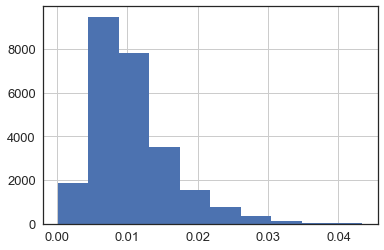

In [332]:
_ = all_data['timediff'].hist()

** eStart, eCentre, and eRadius:**

Summary statistics

In [333]:
all_data[['eStart','eCenter','eRadius']].describe()

eStart       eCenter       eRadius
count  25540.000000  25540.000000  25540.000000
mean      10.164491      9.290771      4.344686
std        6.515438      5.579678      3.989349
min        0.000000      0.056100      0.000000
25%        5.419475      5.175575      1.500000
50%        8.930000      8.260150      3.333300
75%       13.468750     12.318150      6.000000
max       49.136600     37.454500     36.500000

Histograms

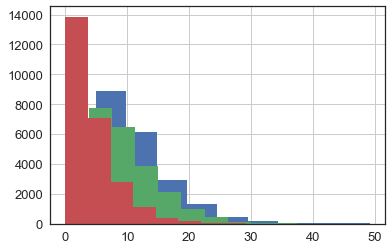

In [334]:
_ = all_data['eStart'].hist()
_ = all_data['eCenter'].hist()
_ = all_data['eRadius'].hist()

#### Lastly, quantify the standard deviation of each feature as a percentage of its range

In [335]:
summary_statistics['weight'] = summary_statistics['Standard Deviation'] / summary_statistics['Range']

In [336]:
list(summary_statistics.sort_values(by='weight', ascending=False)[:5].index)

['direction', 'pres1', 'pres10', 'pres9', 'orient2']

So the above five features exhibit the most variation...

In [337]:
list(summary_statistics.sort_values(by='weight', ascending=False)[-5:].index)

['speedx3', 'speedx9', 'speedy5', 'speedy1', 'speedy6']

And the latter five features exhibit the least.

### Radviz Projections and Scatterplot Matrices
 - The final portion of my data profiling process was to create a Radviz projection and a scatterplot matrix for each feature group.
 - Radviz plots are useful for visualizing N-dimensional data because the influence of each dimension can be interpreted as a balance between the influence of all dimensions.
 - I made radviz plots for each feature group in order to test if any of the subfeatures within a feature group was more or less influential than the rest of the features within its feature group.

**Error Feature Group**

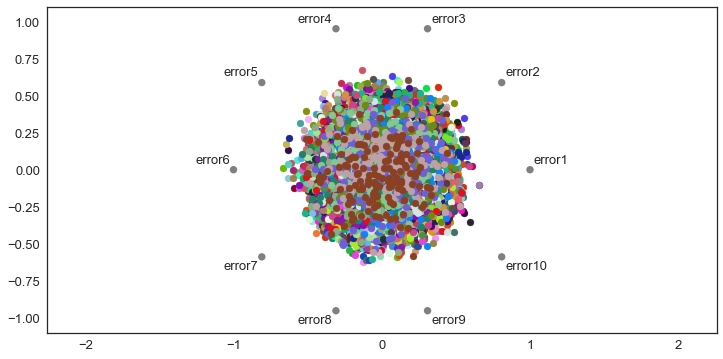

In [338]:
error = all_data.loc[:, 'ID':'error10']

plt.figure(figsize=(12,6))
ax = pd.plotting.radviz(error,'ID')
ax.legend_.remove()

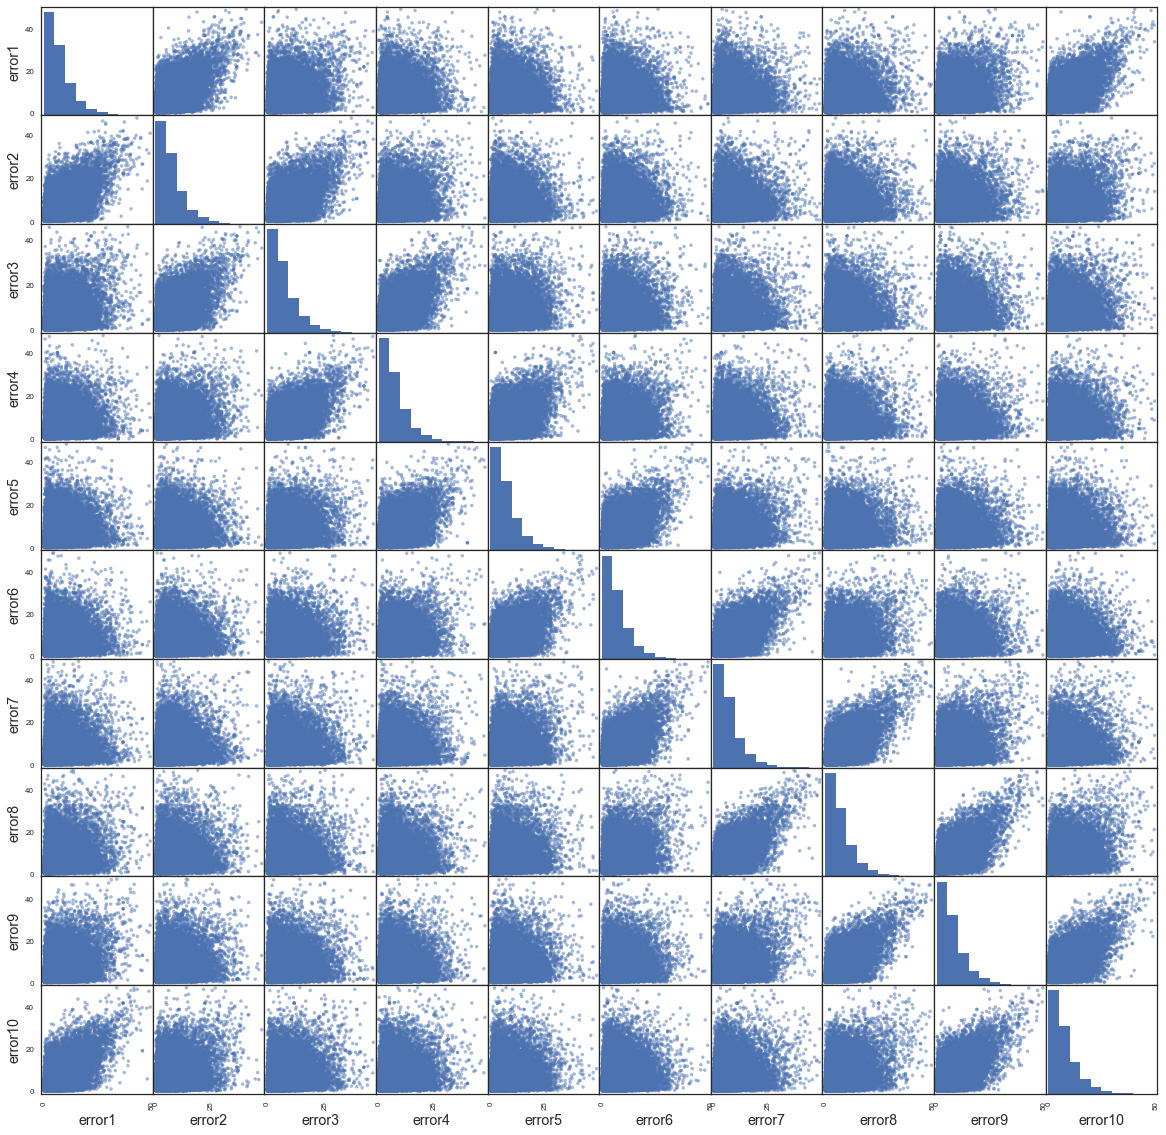

In [339]:
_ = pd.plotting.scatter_matrix(error, figsize=(20,20))

**Speed x Feature Group**

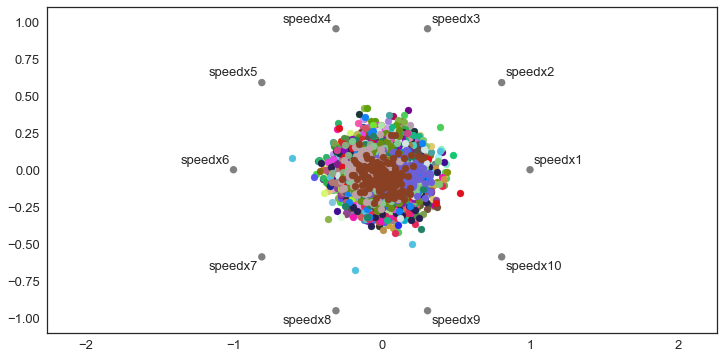

In [340]:
speed_x = pd.concat([all_data[['ID']], all_data.loc[:,'speedx1':'speedx10':2]], axis=1)

plt.figure(figsize=(12,6))
ax = pd.plotting.radviz(speed_x,'ID')
ax.legend_.remove()

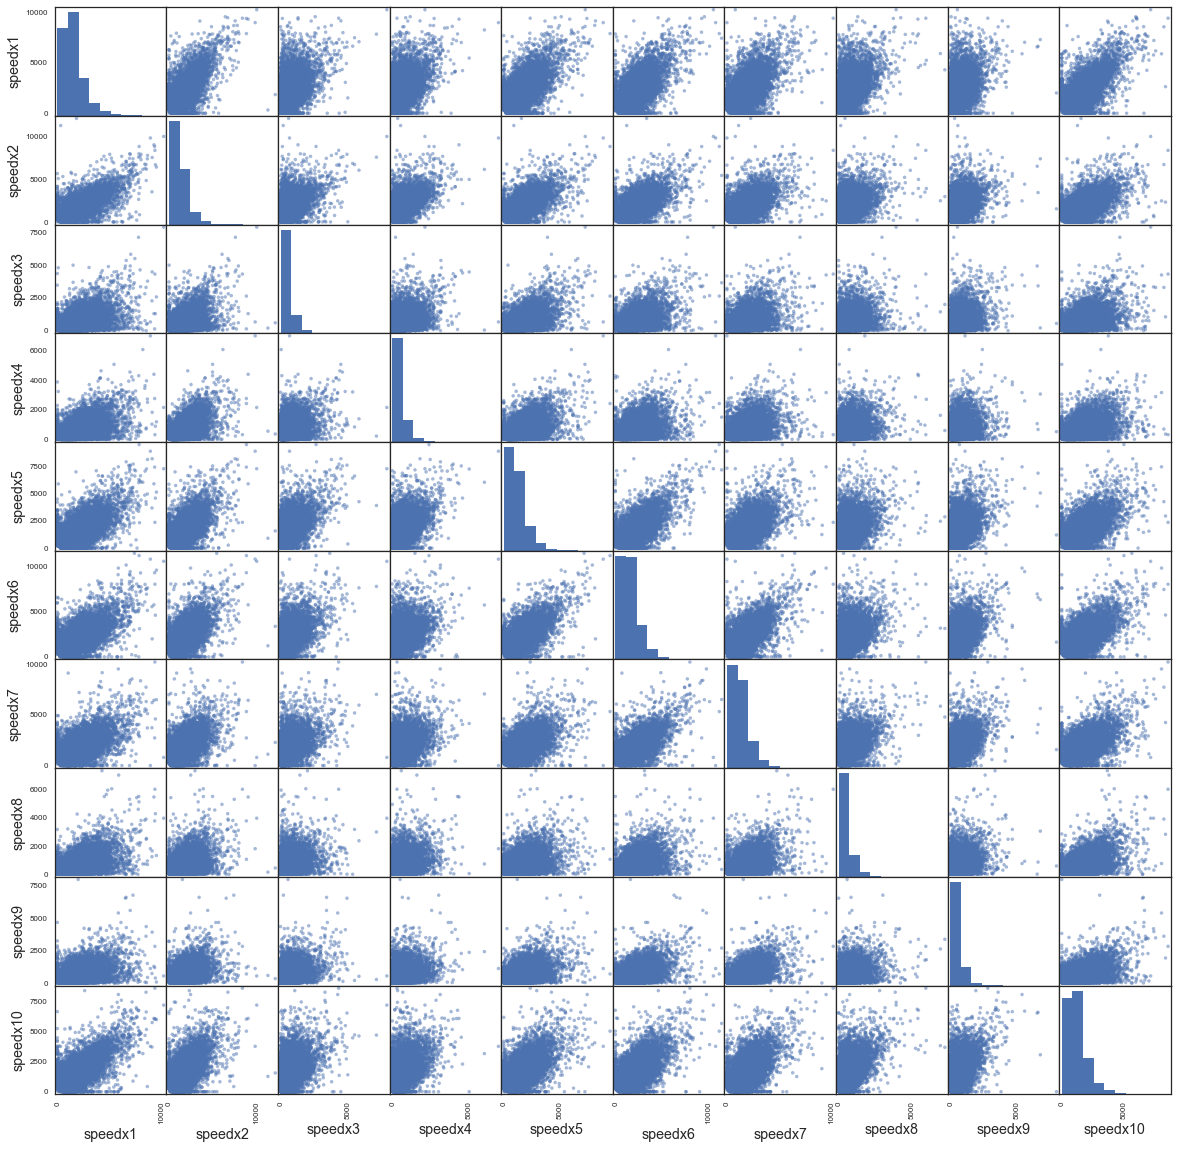

In [341]:
_ = pd.plotting.scatter_matrix(speed_x, figsize=(20,20))

**Speed y Feature Group**

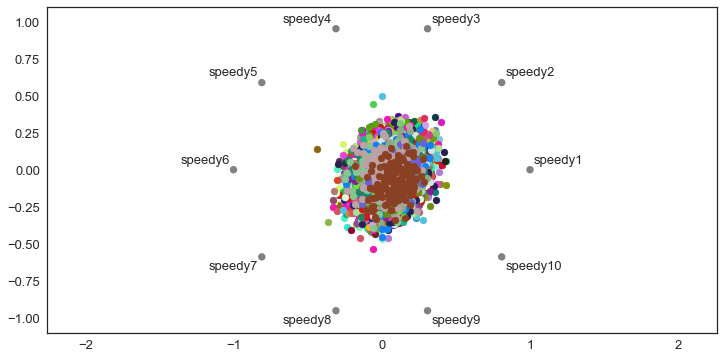

In [342]:
speed_y = pd.concat([all_data[['ID']], all_data.loc[:,'speedy1':'speedy10':2]], axis=1)

plt.figure(figsize=(12,6))
ax = pd.plotting.radviz(speed_y,'ID')
ax.legend_.remove()

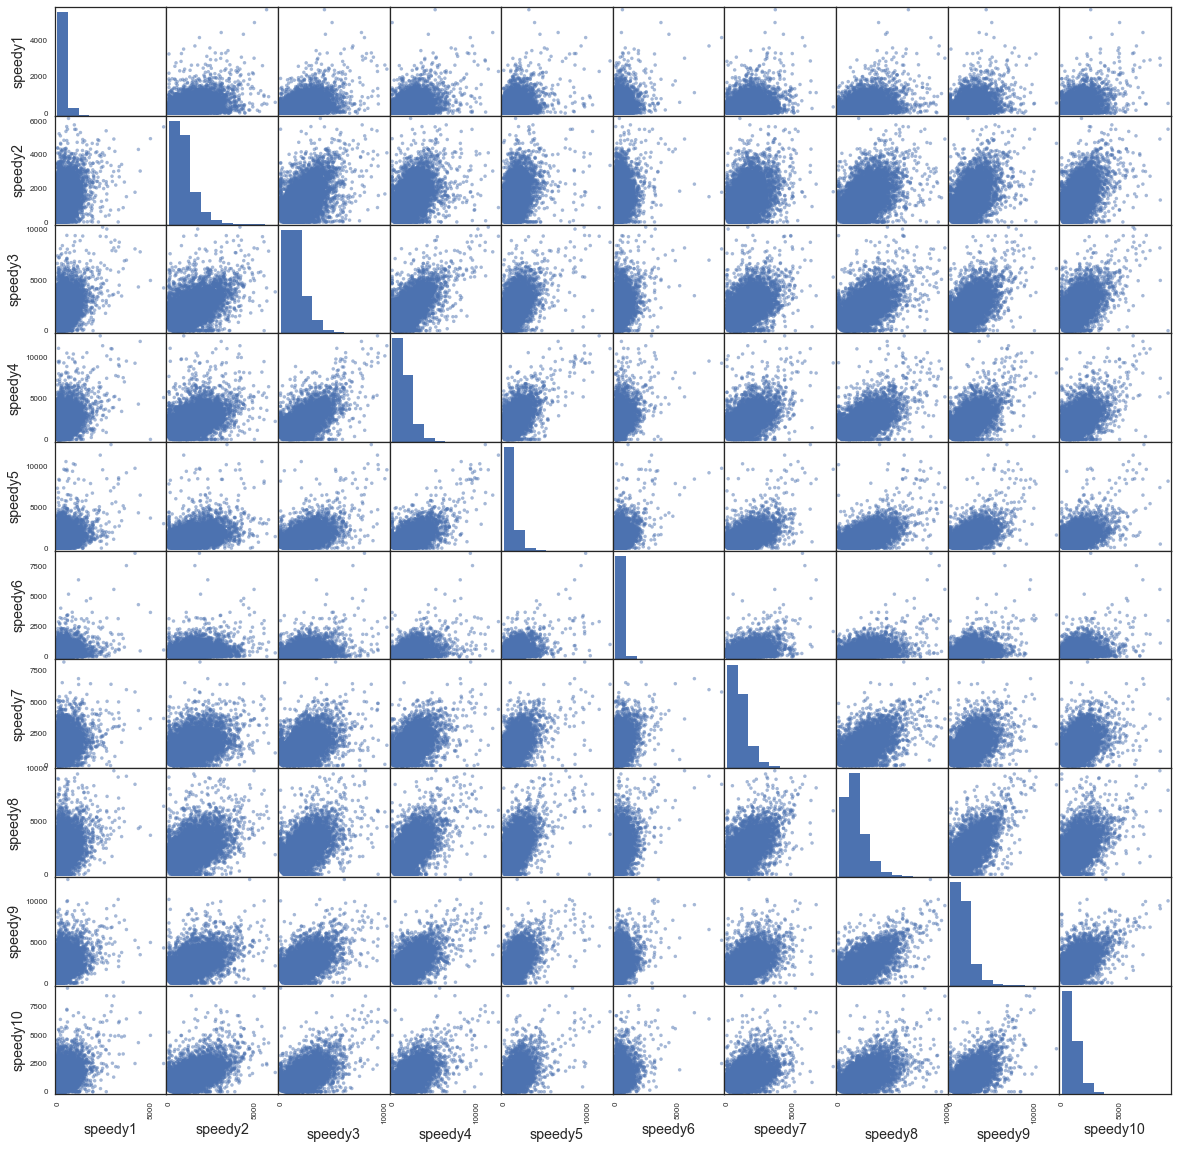

In [343]:
_ = pd.plotting.scatter_matrix(speed_y, figsize=(20,20))

**Pressure Feature Group**

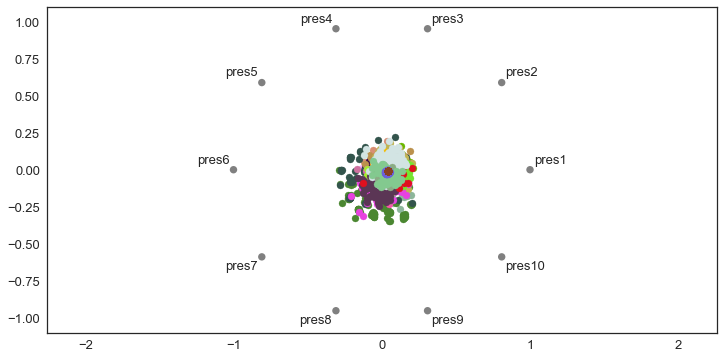

In [344]:
pressure = pd.concat([all_data[['ID']], all_data.loc[:, 'pres1':'pres10']], axis=1)

plt.figure(figsize=(12,6))
ax = pd.plotting.radviz(pressure,'ID')
ax.legend_.remove()

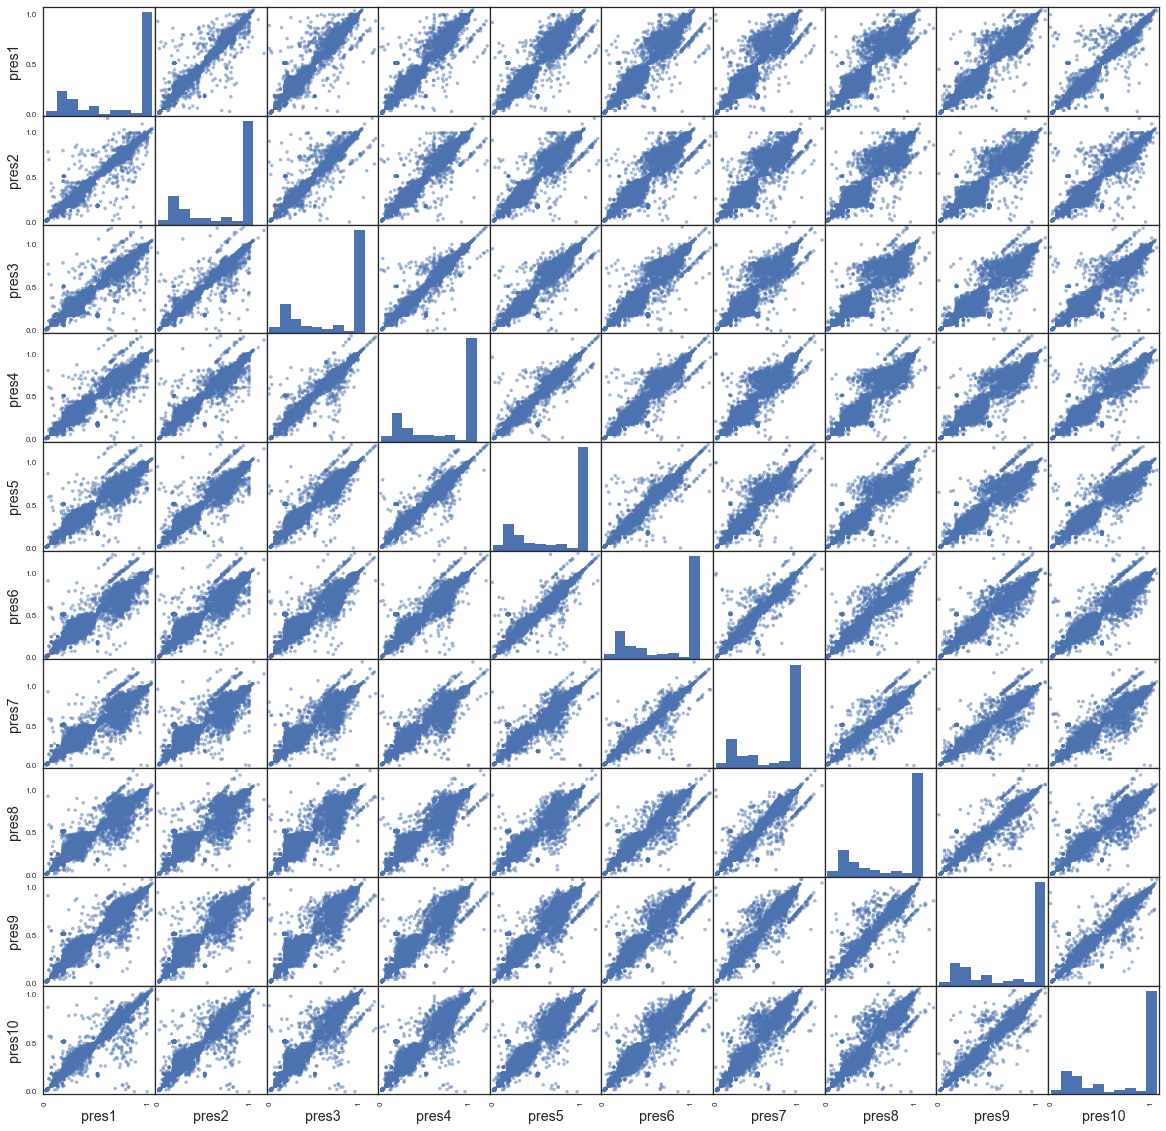

In [345]:
_ = pd.plotting.scatter_matrix(pressure, figsize=(20,20))

**Event Feature Group**

/usr/local/lib/python3.6/site-packages/pandas/plotting/_misc.py:201: RuntimeWarning:

invalid value encountered in true_divide



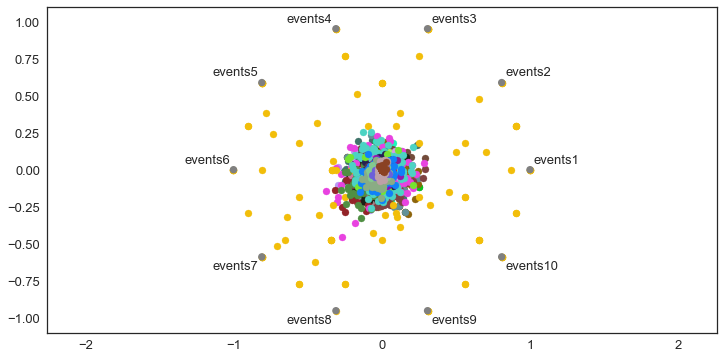

In [346]:
events = pd.concat([all_data[['ID']], all_data.loc[:, 'events1':'events10']], axis=1)

plt.figure(figsize=(12,6))
ax = pd.plotting.radviz(events,'ID')
ax.legend_.remove()

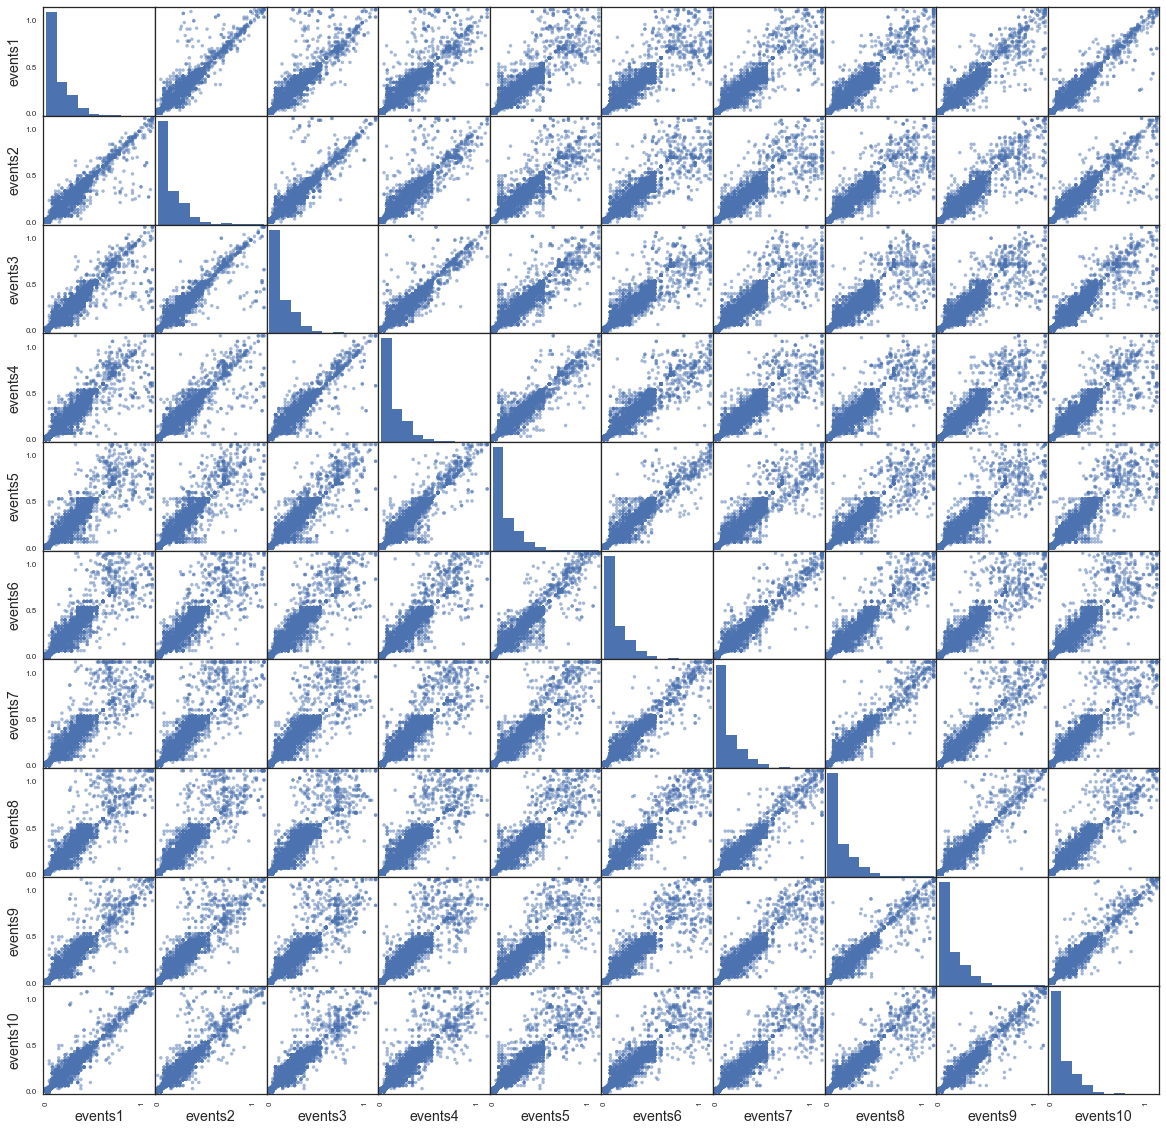

In [347]:
_ = pd.plotting.scatter_matrix(events, figsize=(20,20))

**Annotated plot to identity users that are far away from the central cluster:**

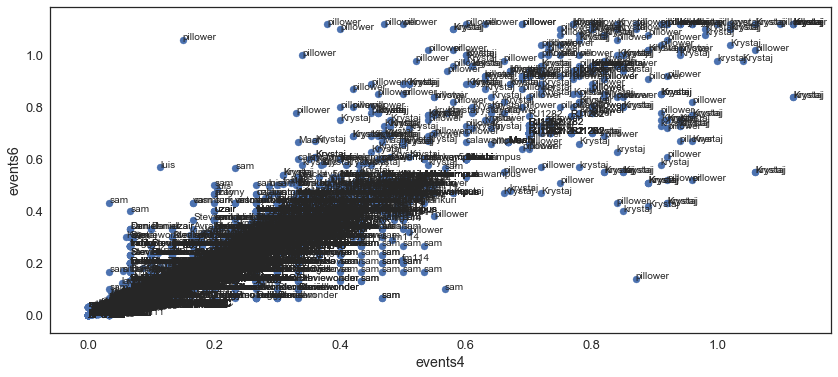

In [348]:
# Generate an annotated snapshot of events4 vs. events6 
# in order to identify users outside of the primary cluster:
plt.figure(figsize=(14,6))
plt.scatter(events["events4"], events["events6"])
plt.xlabel('events4')
plt.ylabel('events6')

for i, row in enumerate(events.values):
    plt.annotate(row[0],xy=(row[4],row[6]),fontsize=10)

**Orientation Feature Group**

/usr/local/lib/python3.6/site-packages/pandas/plotting/_misc.py:201: RuntimeWarning:

invalid value encountered in true_divide



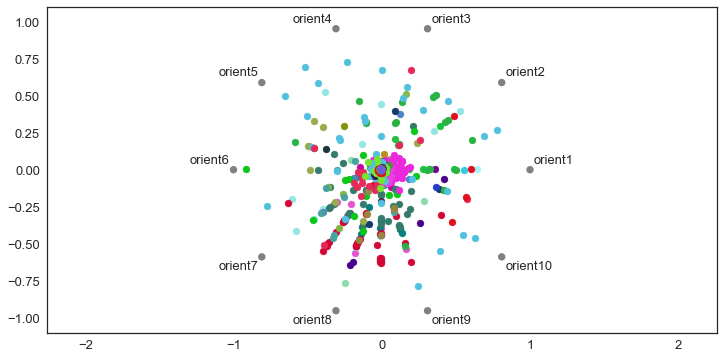

In [349]:
orients = pd.concat([all_data[['ID']], all_data.loc[:, 'orient1':'orient10']], axis=1)

plt.figure(figsize=(12,6))
ax = pd.plotting.radviz(orients,'ID')
ax.legend_.remove()

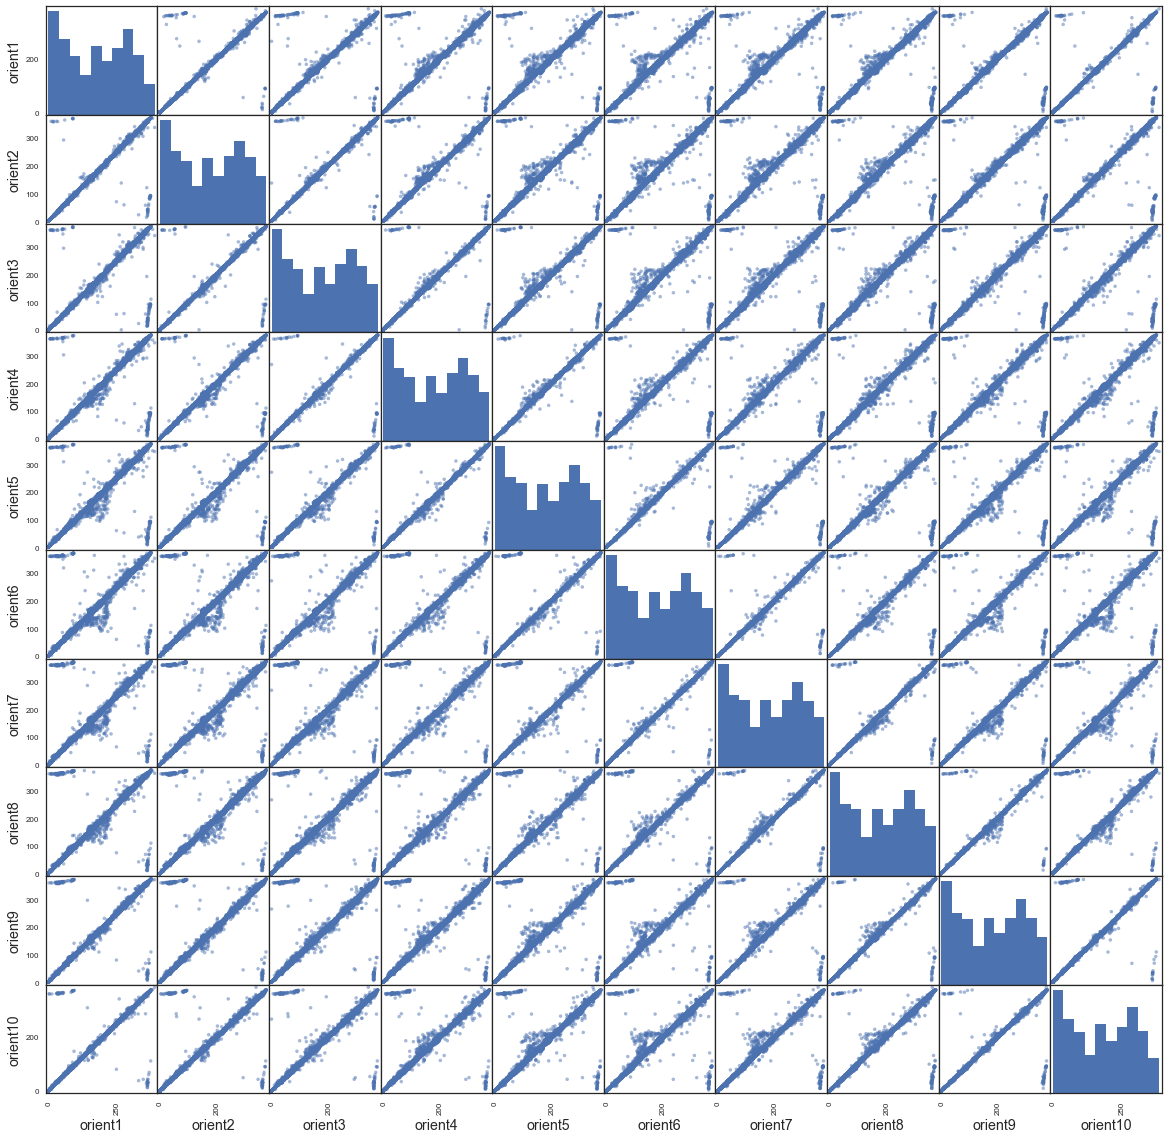

In [350]:
_ = pd.plotting.scatter_matrix(orients, figsize=(20,20))

**Annotated plot to identity users that are far away from the central cluster:**

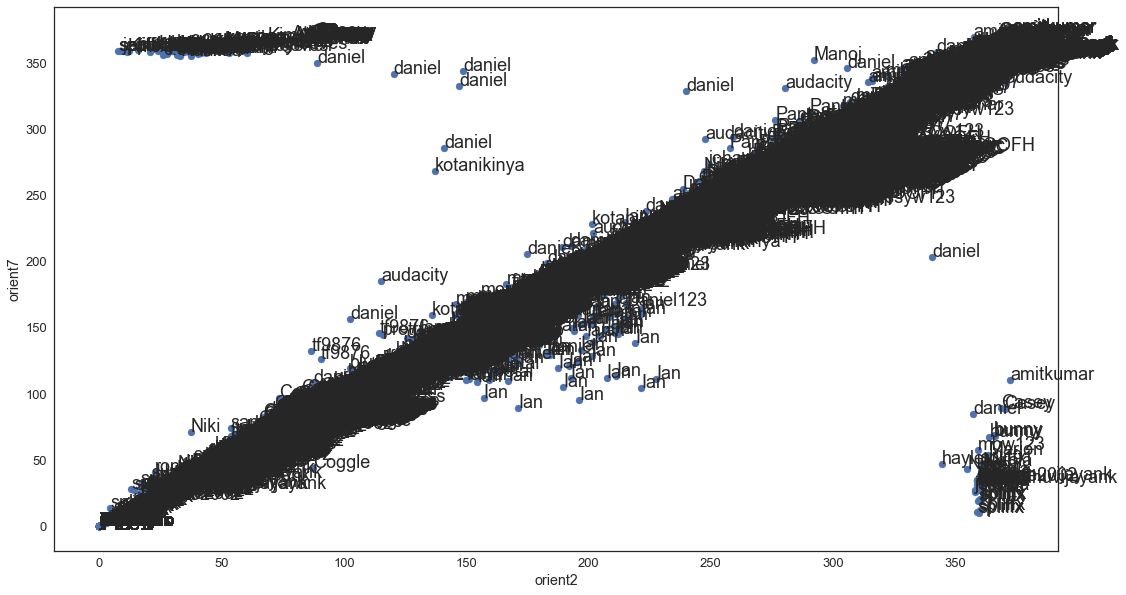

In [351]:
# Generate an annotated snapshot of orient2 vs. orient7
# in order to identify users outside of the primary cluster:
plt.figure(figsize=(18,10))
plt.scatter(orients["orient2"], orients["orient7"])
plt.xlabel('orient2')
plt.ylabel('orient7')

for i, row in enumerate(orients.values):
    plt.annotate(row[0],xy=(row[2],row[7]),fontsize=18)

#### Summary
  - The Radviz projections largely confirmed the results of my summary statistics investigation. 
  - The speed and error portions of the data (x & y) are each distributed as a single, relatively dense cluster.
  - The pressure, events, and orientation feature groups exhibit greater inter-group variance and should lend themselves better to profile clustering.
  - The orientation data in particular exhibits three distinct clusters. This is definitely something to explore. The clustering could be due to device types recording gyroscope data differently, or perhaps there are two groups of people who hold their phones at odd angles relative to the general population.

## Analysis Questions

1.	Of the 65 features in the transformed data, how independent are they from one another? Can some of them be removed?
2.	What can plot.ly parallel coordinates plots reveal in terms of overlap between user profiles?
3.	How much variance is present in the set of all circle vectors obtained from a single user?
4.	Do clear clusters of user profiles exist? If so, can they be given meaningful names?
5.	How widely (or narrowly) are the user profiles dispersed within the entire 65-dimensional feature space?
6.	How much of the variation in a given circle vector can be attributed to device type?